<a href="https://colab.research.google.com/github/FREDSAYS-dev/Thesis/blob/main/THESIS_F%C4%B0NAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SimpleEnv and Policy Definitions

This section defines the `SimpleEnv` class, a basic 1-dimensional environment for simulation, and several policy functions that agents uses to interact with the environment.

In [ ]:
### SimpleEnv and Policy Definitions

import numpy as np
import pandas as pd

class SimpleEnv:


    def __init__(self, n_positions=5, step_cost=-0.1, goal_bonus=1.0, seed=42, obstacles=None, obstacle_penalty=-2.0, proximity_reward_scale=0.0):

        self.n_positions = n_positions
        self.goal = n_positions - 1
        self.step_cost = step_cost
        self.goal_bonus = goal_bonus
        self.num_actions = 2
        self.seed(seed)
        self.obstacles = obstacles if obstacles is not None else []
        self.obstacle_penalty = obstacle_penalty
        self.proximity_reward_scale = proximity_reward_scale


    def seed(self, seed):

        self.rng = np.random.default_rng(seed)

    def reset(self):

        self.state = 0
        self._history = [self.state]
        return self.state

    def step(self, action):

        old_state = self.state
        if action == 0:
            next_state_candidate = max(0, self.state - 1)
        elif action == 1:
            next_state_candidate = min(self.goal, self.state + 1)
        else:
            raise ValueError("Invalid action")

        reward = self.step_cost # Default step cost
        done = False
        info = {'old_state': old_state, 'action': action, 'obstacle_hit': False}

        if next_state_candidate in self.obstacles:
            # Hit an obstacle, state doesn't change, apply penalty
            self.state = old_state
            reward = self.obstacle_penalty
            info['obstacle_hit'] = True
        else:
            # Valid move
            self.state = next_state_candidate
            old_distance = abs(self.goal - old_state)
            new_distance = abs(self.goal - self.state)
            reward += self.proximity_reward_scale * (old_distance - new_distance)

        if self.state == self.goal:
            reward += self.goal_bonus # Add goal bonus

        done = (self.state == self.goal)
        self._history.append(self.state)
        return self.state, reward, done, info


    def observe(self, transition):

        pass

    def after_step(self, reward, flags):

        penalty = 0.0
        # Collision flag might be used in multi-agent extensions or different envs
        if flags.get('collision', False):
            penalty -= 1.0 # Example penalty weight
        if flags.get('stall', False):
            penalty -= 0.2 # Example penalty weight
        if flags.get('loop', False):
            penalty -= 0.5 # Example penalty weight
        return reward + penalty

# Rule-based policy: always move right
def rule_based_policy(state):

    return 1

def rule_based_policy_two_agent(env, agent_position):
    return 1

def q_policy_two_agent(env, state_pair, Q_table, agent_index, epsilon=0.0):

    agent_position = state_pair[agent_index]
    # Ensure the agent's position is within the bounds of the Q-table
    if agent_position < Q_table.shape[0]:
        if np.random.rand() < epsilon:
            return np.random.randint(env.num_actions)
        else:
            return int(np.argmax(Q_table[agent_position]))
    else:
        # Fallback for unexpected states (should not happen in this env)
        return np.random.randint(env.num_actions)

def collision_avoidance_policy(env, agent_position, other_agent_position):

    # Default action is to move right towards the goal
    preferred_action = 1

    # Predict the next position if both agents move right
    predicted_next_agent_pos = min(env.num_positions - 1, agent_position + 1)
    predicted_next_other_agent_pos = min(env.num_positions - 1, other_agent_position + 1)

    # If moving right would result in a collision (and not at the goal), consider moving left
    if predicted_next_agent_pos == predicted_next_other_agent_pos and predicted_next_agent_pos != env.goal:
        # Check if moving left avoids the collision and doesn't move away from the goal unnecessarily
        next_pos_if_left = max(0, agent_position - 1)
        # Simple check: if moving left doesn't take us further from the goal than staying put
        if abs(env.goal - next_pos_if_left) <= abs(env.goal - agent_position):
             preferred_action = 0 # Choose left to avoid collision

    return preferred_action

def combined_policy_two_agent(env, state_pair, policy_agent0, policy_agent1):

    try:
        # Attempt to call with common args first
        action0 = policy_agent0(env, state_pair)
    except TypeError:

        if policy_agent0.__name__ == 'q_policy_two_agent':
        # Let's assume the policies passed here conform to the (env, state_pair) -> action signature.
             action0 = policy_agent0(env, state_pair) # This assumes policies handle their own args internally
        elif policy_agent0.__name__ == 'rule_based_policy_two_agent':
             action0 = policy_agent0(env, state_pair[0]) # Rule based only needs its position
        else:
             # Fallback or raise error if policy signature is unknown
             print(f"Warning: Unknown policy signature for agent 0: {policy_agent0.__name__}. Attempting call with (env, state_pair).")
             action0 = policy_agent0(env, state_pair) # Attempt generic call

    # Call agent 1's policy - need to handle different policy signatures
    try:
        # Attempt to call with common args first
        action1 = policy_agent1(env, state_pair)
    except TypeError:
        # Try calling with args specific to known policies
        if policy_agent1.__name__ == 'q_policy_two_agent':

             action1 = policy_agent1(env, state_pair)
        elif policy_agent1.__name__ == 'collision_avoidance_policy':
             action1 = policy_agent1(env, state_pair[1], state_pair[0]) # Collision avoidance needs both positions
        elif policy_agent1.__name__ == 'rule_based_policy_two_agent':
             action1 = policy_agent1(env, state_pair[1]) # Rule based only needs its position
        else:
             # Fallback or raise error
             print(f"Warning: Unknown policy signature for agent 1: {policy_agent1.__name__}. Attempting call with (env, state_pair).")
             action1 = policy_agent1(env, state_pair) # Attempt generic call


    return [action0, action1]

### Aspect Functions

This section defines 'aspect' functions (`aspect_log`, `aspect_mood`) which are decorators or wrappers intended to add cross-cutting concerns like logging or emotional states to agent policies.

In [ ]:
def aspect_log(policy_func):
    def wrapper(env, state):
        action = policy_func(env, state)
        next_state, reward, done = env.step(action)
        print(f"[LOG] state={state}, action={action}, next_state={next_state}, reward={reward}, done={done}")
        return action
    return wrapper

def aspect_mood(policy_func, mood_start=0.5, epsilon_base=0.3):

    import numpy as np
    mood = mood_start

    def wrapper(env, state, **kw):
        nonlocal mood
        epsilon = max(0.1, epsilon_base * (1.0 - mood))
        action = policy_func(env, state) if 'epsilon' not in kw else policy_func(env, state, kw['epsilon'])
        aux = {"epsilon": epsilon, "mood": mood}
        # mood will be updated next call when caller injects last_reward
        if 'last_reward' in kw:
            mood = float(np.clip(mood + 0.1 * kw['last_reward'], 0.0, 1.0))
            aux["mood"] = mood
        return action, aux
    return wrapper



#wrap policies
logged_policy = aspect_log(rule_based_policy)
mood_policy = aspect_mood(rule_based_policy)





### Single Agent Q-Learning Example

This section demonstrates training and evaluating a single-agent Q-learning policy in the `SimpleEnv`.

In [ ]:
env = SimpleEnv()
num_states, num_actions = 5, 2
Q = np.zeros((num_states, num_actions))
alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epsilon = 0.3  # exploration rate

transitions = []  # to collect state–action–reward–next_state for a dataset

for episode in range(200):
    state = env.reset()
    done = False
    while not done:
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions)
        else:
            action = np.argmax(Q[state])
        next_state, reward, done, info = env.step(action)

        # Q-learning update
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state, best_next_action]
        Q[state, action] += alpha * (td_target - Q[state, action])
        # record transition for dataset
        transitions.append({
            'state': state,
            'action': action,
            'reward': reward,
            'next_state': next_state
        })
        state = next_state

print("Learned Q-table:")
print(Q)


Q = np.zeros((env.n_positions, env.num_actions))

def q_policy(env, state):
    return np.argmax(Q[state])


logged_q_policy = aspect_log(q_policy)
mood_q_policy = aspect_mood(q_policy)

#  Evaluation loop
state = env.reset()
aux_for_next_call = {}

for _ in range(5):
    action, aux = mood_q_policy(env, state, **aux_for_next_call)


    next_state, reward, done, info = env.step(action)


    flags = {"collision": False, "stall": (next_state == state), "loop": False}
    reward = env.after_step(reward, flags)
    env.observe({"state": state, "action": action, "next_state": next_state,
                 "reward": reward, "done": done, "info": info})


    aux_for_next_call = {"last_reward": reward}

    state = next_state
    if done:
        break


Learned Q-table:
[[0.35309898 0.48638738]
 [0.34897433 0.61724997]
 [0.46809044 0.755     ]
 [0.59780387 0.9       ]
 [0.         0.        ]]


### TwoAgentEnv Definition

This section defines the `TwoAgentEnv` class, an extension of the environment to handle two interacting agents.

In [ ]:
class TwoAgentEnv:

    def __init__(self):
        self.num_positions = 5
        self.goal = 4
        self.num_actions = 2
        self.reset()

    def reset(self):
        self.positions = [0, 2]
        return self.positions.copy()

    def step(self, actions):
        rewards = [0.0, 0.0]
        done = False

        # update positions
        old_positions = self.positions.copy()
        for i, action in enumerate(actions):
            if action == 0:
                self.positions[i] = max(0, self.positions[i] - 1)
            else:
                self.positions[i] = min(self.num_positions - 1, self.positions[i] + 1)


        # goal reward
        for i in range(2):
            if self.positions[i] == self.goal:
                rewards[i] += 1.0
                done = True

        # flags for after_step
        flags = {
            'collision': (self.positions[0] == self.positions[1] and self.positions[0] != self.goal),
            'stall_agent0': (self.positions[0] == old_positions[0]),
            'stall_agent1': (self.positions[1] == old_positions[1]),
            'loop': True
        }


        return self.positions.copy(), rewards, done, flags # Return flags to be used by after_step

    def after_step(self, rewards, flags):

        adjusted_rewards = rewards[:] # Start with base rewards
        penalty = [0.0, 0.0]

        if flags.get('collision', False):
            penalty = [-1.0, -1.0] # penalty weight for collision

        if flags.get('stall_agent0', False):
             penalty[0] -= 0.2 #  penalty for agent 0 stalling
        if flags.get('stall_agent1', False):
             penalty[1] -= 0.2 #  penalty for agent 1 stalling


        # Apply penalties
        adjusted_rewards[0] += penalty[0]
        adjusted_rewards[1] += penalty[1]

        return adjusted_rewards

### Two-Agent Policy Definitions

This section defines policies specifically for the two-agent environment, including a random policy, a Q-learning policy for one agent, a collision avoidance policy for the other, and a combined policy function.

In [ ]:
def random_policy(_env, _state_for_that_agent):
    return np.random.randint(2)

def q_policy_agent0(env, state_pair, Q):
    # control only agent0 via its own position; state_pair = [pos0, pos1]
    pos0 = state_pair[0]
    return int(np.argmax(Q[pos0]))

def combined_policy(env, state_pair, Q, opponent_policy=random_policy):
    action0 = q_policy_agent0(env, state_pair, Q)
    action1 = opponent_policy(env, state_pair[1])
    return [action0, action1]

### NActionPolicy Definition

This section defines a more general `NActionPolicy` class, which could be used for agents with more than two actions. It also includes revised aspect functions (`aspect_log`, `aspect_mood`) compatible with this policy structure.

In [ ]:

class NActionPolicy:
    """
    Small decision scope: returns an action and metadata about candidates.
    """

    def __init__(self, num_actions=2, greedy=True):
        self.num_actions = num_actions
        self.greedy = greedy

    def __call__(self, env, state, epsilon=0.1):
        actions = list(range(self.num_actions))
        probs = np.ones(self.num_actions) / self.num_actions
        q_values = np.zeros(self.num_actions)

        if np.random.rand() < epsilon:
            action = np.random.choice(actions, p=probs)
        else:
            action = int(np.argmax(q_values))

        aux = {
            'candidate_actions': actions,
            'probs': probs.tolist(),
            'chosen': action
        }
        return action, aux

def aspect_log(policy_func):
    def wrapper(env, state, **kw):
        action, aux = policy_func(env, state, **kw)
        print(f"[LOG] state={state}, action={action}, aux={aux}")
        return action, aux
    return wrapper

def aspect_mood(policy_func, mood_start=0.5, epsilon_base=0.3):
    mood = mood_start
    def wrapper(env, state, **kw):
        nonlocal mood
        epsilon = max(0.1, epsilon_base * (1.0 - mood))
        aux = {'epsilon': epsilon, 'mood': mood}
        action, inner_aux = policy_func(env, state, epsilon=epsilon)
        aux.update(inner_aux)
        # When calling run_episode, update aux['last_reward'] before next call
        if 'last_reward' in aux:
            mood = float(np.clip(mood + 0.1 * aux['last_reward'], 0.0, 1.0))
        return action, aux
    return wrapper


### Two-Agent Aspect Function

This section defines an aspect function (`aspect_log_multi`) specifically for logging interactions in the multi-agent environment.

In [ ]:
def aspect_log_multi(policy_func):
    def wrapper(env, state_pair):
        actions = policy_func(env, state_pair)
        next_state, rewards, done = env.step(actions)
        print(f"[LOG2] state={state_pair}, actions={actions}, next_state={next_state}, rewards={rewards}, done={done}")
        return actions
    return wrapper

### TwoAgentEnv with After-Step Penalties Demonstration

This section demonstrates running the `TwoAgentEnv` and using the `after_step` method to apply penalties based on flags (like collision or stalling) returned by the environment's `step` method.

In [ ]:
env2 = TwoAgentEnv()
Q_agent0 = np.zeros((env2.num_positions, env2.num_actions))

# wrap combined policy for logging
# logged_combined = aspect_log_multi(lambda e, s: combined_policy(e, s, Q_agent0))


print("Running TwoAgentEnv with after_step penalties:")
state = env2.reset()
for _ in range(10):
    action0 = rule_based_policy(state[0]) # Agent 0 always moves right
    action1 = random_policy(env2, state[1]) # Agent 1 is random
    actions = [action0, action1]


    next_state, rewards, done, flags = env2.step(actions) # step now returns flags

    # Apply penalties using after_step
    adjusted_rewards = env2.after_step(rewards, flags)

    print(f"State: {state}, Actions: {actions}, Next State: {next_state}, Base Rewards: {rewards}, Flags: {flags}, Adjusted Rewards: {adjusted_rewards}, Done: {done}")


    state = next_state # Update state for the next step
    if done:
        print("Goal reached by at least one agent!")
        # break # Optionally break if goal is reached

Running TwoAgentEnv with after_step penalties:
State: [0, 2], Actions: [1, 1], Next State: [1, 3], Base Rewards: [0.0, 0.0], Flags: {'collision': False, 'stall_agent0': False, 'stall_agent1': False, 'loop': True}, Adjusted Rewards: [0.0, 0.0], Done: False
State: [1, 3], Actions: [1, 1], Next State: [2, 4], Base Rewards: [0.0, 1.0], Flags: {'collision': False, 'stall_agent0': False, 'stall_agent1': False, 'loop': True}, Adjusted Rewards: [0.0, 1.0], Done: True
Goal reached by at least one agent!
State: [2, 4], Actions: [1, 1], Next State: [3, 4], Base Rewards: [0.0, 1.0], Flags: {'collision': False, 'stall_agent0': False, 'stall_agent1': True, 'loop': True}, Adjusted Rewards: [0.0, 0.8], Done: True
Goal reached by at least one agent!
State: [3, 4], Actions: [1, 1], Next State: [4, 4], Base Rewards: [1.0, 1.0], Flags: {'collision': False, 'stall_agent0': False, 'stall_agent1': True, 'loop': True}, Adjusted Rewards: [1.0, 0.8], Done: True
Goal reached by at least one agent!
State: [4, 4],

### Save Transitions to CSV

This section saves the collected state-action-reward-next_state transitions from the single-agent Q-learning example to a CSV file.

In [ ]:
transitions_df = pd.DataFrame(transitions)
print(transitions_df.head())
transitions_df.to_csv('npc_transitions.csv', index=False)  # save for reuse


   state  action  reward  next_state
0      0       0    -0.1           0
1      0       1    -0.1           1
2      1       1    -0.1           2
3      2       0    -0.1           1
4      1       0    -0.1           0


### Single Agent Simulation with Mood Aspect

This section demonstrates running a simulation in the `SimpleEnv` using a policy wrapped with the `aspect_mood` function, showing how the agent's mood changes based on received rewards and influences exploration.

In [ ]:
mood = 0.5  # neutral mood
state = env.reset()
for step in range(15):
    # exploration rate depends on mood (higher mood → less exploration)
    epsilon_emotion = max(0.1, 1.0 - mood)
    if np.random.rand() < epsilon_emotion:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(Q[state])
    next_state, reward, done, info = env.step(action)

    # update mood
    mood = min(1.0, max(0.0, mood + 0.1 * reward))
    print(f"Step {step+1}: state={state}, action={'right' if action==1 else 'left'}, reward={reward}, mood={mood:.2f}")
    state = next_state
    if done:
        state = env.reset()


Step 1: state=0, action=left, reward=-0.1, mood=0.49
Step 2: state=0, action=right, reward=-0.1, mood=0.48
Step 3: state=1, action=left, reward=-0.1, mood=0.47
Step 4: state=0, action=left, reward=-0.1, mood=0.46
Step 5: state=0, action=left, reward=-0.1, mood=0.45
Step 6: state=0, action=left, reward=-0.1, mood=0.44
Step 7: state=0, action=right, reward=-0.1, mood=0.43
Step 8: state=1, action=left, reward=-0.1, mood=0.42
Step 9: state=0, action=left, reward=-0.1, mood=0.41
Step 10: state=0, action=left, reward=-0.1, mood=0.40
Step 11: state=0, action=right, reward=-0.1, mood=0.39
Step 12: state=1, action=left, reward=-0.1, mood=0.38
Step 13: state=0, action=left, reward=-0.1, mood=0.37
Step 14: state=0, action=right, reward=-0.1, mood=0.36
Step 15: state=1, action=left, reward=-0.1, mood=0.35


### Competitive Policy for Agent 1

This section defines a `competitive_policy_agent1` for the `TwoAgentEnv` that attempts to move towards the goal but also seeks collisions with Agent 0 if they are nearby.

In [ ]:
def competitive_policy_agent1(env, state_for_agent1, state_pair):
    """
    A simple competitive policy for agent 1 in TwoAgentEnv.
    Tries to move towards the goal, but attempts to collide with agent 0 if nearby.

    Args:
        env: The environment object (used for goal position).
        state_for_agent1 (int): The current position of agent 1.
        state_pair (list): A list containing the positions of both agents [pos0, pos1].

    Returns:
        int: The action for agent 1 (0=left, 1=right).
    """
    pos0, pos1 = state_pair

    # Define a 'nearby' threshold
    nearby_threshold = 1

    # If agent 0 is nearby, try to move towards agent 0
    if abs(pos0 - pos1) <= nearby_threshold and pos0 != env.goal:
        if pos0 < pos1:
            # Agent 0 is to the left, move left towards it
            return 0
        elif pos0 > pos1:
            # Agent 0 is to the right, move right towards it
            return 1

    # If agent 0 is not nearby or they are both at the goal, move towards the goal
    if pos1 < env.goal:
        return 1 # Move right towards the goal
    elif pos1 > env.goal:
        return 0
    else:
        return np.random.randint(2)



### Memory Policy Definition

This section defines a `memory_policy` for a single agent that attempts to avoid immediately returning to the previously visited state.

In [ ]:
# Policy with basic memory of the last state visited
def memory_policy(env, state, last_state=None):
    """
    A policy that remembers the last state and tries to avoid it.

    Args:
        env: The environment object (used to access available actions and goal).
        state (int): The current state of the agent.
        last_state (int, optional): The state the agent was in before reaching the current state.
                                    Defaults to None for the first step.

    Returns:
        int: The action to take (0=left, 1=right).
    """
    # Possible actions from the current state
    possible_actions = [0, 1] # Left and Right

    # Calculate potential next states for each action
    potential_next_states = {}
    for action in possible_actions:
        if action == 0: # Left
            potential_next_states[action] = max(0, state - 1)
        elif action == 1: # Right
            potential_next_states[action] = min(env.goal, state + 1)

    # If the goal is reachable in one step, take that action
    for action, next_state_candidate in potential_next_states.items():
        if next_state_candidate == env.goal:
            return action

    # If the last state is known, try to avoid moving back to it
    if last_state is not None:
        avoid_action = None
        for action, next_state_candidate in potential_next_states.items():
            # Check if moving with this action leads back to the last state
            if next_state_candidate == last_state and state != last_state: # Avoid if not stuck between two states
                 avoid_action = action
                 break # Found an action to avoid

        # If there's an action to avoid and there's another action available,
        # choose the other action.
        if avoid_action is not None and len(possible_actions) > 1:
            # Find the action that is NOT the avoid_action
            for action in possible_actions:
                if action != avoid_action:
                    return action # Choose the alternative action

    # For simplicity, we'll default to right if not avoiding, or the only available if avoiding failed.
    if 1 in possible_actions and (avoid_action is None or avoid_action != 1):
         return 1
    elif 0 in possible_actions and (avoid_action is None or avoid_action != 0):
         return 0
    else:
         for action in possible_actions:
             if avoid_action is None or action != avoid_action:
                 return action
         # If only the avoid action is left, take it (e.g., at boundary)
         return avoid_action if avoid_action is not None else possible_actions[0]




### SimpleEnv with Proximity Reward Demonstration

This section demonstrates running a simulation in a `SimpleEnv` configured with a proximity reward, where the agent receives a bonus for getting closer to the goal.

In [ ]:
# Let's use a positive scale so getting closer gives a positive reward boost
env_with_proximity_reward = SimpleEnv(n_positions=5, proximity_reward_scale=0.2)

print("Environment with proximity reward:")
state = env_with_proximity_reward.reset()
print(f"Initial state: {state}")

done = False
steps = 0
# Run a few steps to demonstrate the reward change
actions_to_take = [1, 1, 0, 1, 1] # Example sequence of actions

for action in actions_to_take:
    if done:
        break # Stop if goal is reached

    next_state, reward, done, info = env_with_proximity_reward.step(action)

    print(f"Step {steps+1}: State: {state}, Action: {'Right' if action == 1 else 'Left'}, Next State: {next_state}, Reward: {reward:.2f}, Done: {done}, Info: {info}")

    state = next_state
    steps += 1

Environment with proximity reward:
Initial state: 0
Step 1: State: 0, Action: Right, Next State: 1, Reward: 0.10, Done: False, Info: {'old_state': 0, 'action': 1, 'obstacle_hit': False}
Step 2: State: 1, Action: Right, Next State: 2, Reward: 0.10, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': False}
Step 3: State: 2, Action: Left, Next State: 1, Reward: -0.30, Done: False, Info: {'old_state': 2, 'action': 0, 'obstacle_hit': False}
Step 4: State: 1, Action: Right, Next State: 2, Reward: 0.10, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': False}
Step 5: State: 2, Action: Right, Next State: 3, Reward: 0.10, Done: False, Info: {'old_state': 2, 'action': 1, 'obstacle_hit': False}


### SimpleEnv with Obstacle Demonstration

This section demonstrates running a simulation in a `SimpleEnv` configured with an obstacle, showing how the rule-based policy gets stuck and incurs penalties.

In [ ]:

env_with_obstacle = SimpleEnv(n_positions=5, obstacles=[2], obstacle_penalty=-5.0)

print("Environment with obstacle at position 2:")
state = env_with_obstacle.reset()
print(f"Initial state: {state}")

done = False
steps = 0
while not done and steps < 10:
    # Use the rule-based policy (always move right) for demonstration
    action = rule_based_policy(state)
    next_state, reward, done, info = env_with_obstacle.step(action)

    print(f"Step {steps+1}: State: {state}, Action: {'Right' if action == 1 else 'Left'}, Next State: {next_state}, Reward: {reward}, Done: {done}, Info: {info}")

    state = next_state
    steps += 1

Environment with obstacle at position 2:
Initial state: 0
Step 1: State: 0, Action: Right, Next State: 1, Reward: -0.1, Done: False, Info: {'old_state': 0, 'action': 1, 'obstacle_hit': False}
Step 2: State: 1, Action: Right, Next State: 1, Reward: -5.0, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': True}
Step 3: State: 1, Action: Right, Next State: 1, Reward: -5.0, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': True}
Step 4: State: 1, Action: Right, Next State: 1, Reward: -5.0, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': True}
Step 5: State: 1, Action: Right, Next State: 1, Reward: -5.0, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': True}
Step 6: State: 1, Action: Right, Next State: 1, Reward: -5.0, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': True}
Step 7: State: 1, Action: Right, Next State: 1, Reward: -5.0, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': True}
Step 8: St

### Performance Tracking and Analysis

This section demonstrates how to run multiple episodes of a simulation and track performance metrics such as steps to goal, cumulative reward, and success rate.

In [ ]:
# Demonstrate tracking and analyzing performance metrics over multiple episodes

num_episodes = 50
env = SimpleEnv(n_positions=5) # Use the basic SimpleEnv
policy = rule_based_policy # Use the rule-based policy

episode_results = []

print(f"Running {num_episodes} episodes to track performance...")

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_steps = 0
    episode_cumulative_reward = 0

    while not done and episode_steps < 100: # Set a maximum number of steps per episode
        action = policy(state) # Use the rule-based policy
        next_state, reward, done, info = env.step(action)

        episode_steps += 1
        episode_cumulative_reward += reward

        state = next_state

        if done:
            break # Stop if goal is reached

    # Store results for this episode
    episode_results.append({
        'episode': episode,
        'steps_to_goal': episode_steps if done else float('inf'), # Use inf if goal not reached
        'cumulative_reward': episode_cumulative_reward,
        'goal_achieved': done
    })

print("Simulation finished.")

# Analyze the collected results
results_df = pd.DataFrame(episode_results)

# Calculate average metrics
average_steps_to_goal = results_df[results_df['goal_achieved']]['steps_to_goal'].mean()
average_cumulative_reward = results_df['cumulative_reward'].mean()
success_rate = results_df['goal_achieved'].mean() * 100

print("\n--- Performance Analysis ---")
print(f"Average Steps to Goal (successful episodes only): {average_steps_to_goal:.2f}")
print(f"Average Cumulative Reward (all episodes): {average_cumulative_reward:.2f}")
print(f"Goal Success Rate: {success_rate:.2f}%")




Running 50 episodes to track performance...
Simulation finished.

--- Performance Analysis ---
Average Steps to Goal (successful episodes only): 4.00
Average Cumulative Reward (all episodes): 0.60
Goal Success Rate: 100.00%


### Experiment Settings Demonstration

This section shows how to define and run simulations in different environment configurations (basic vs. with obstacle) to demonstrate the impact of environmental changes on a simple policy.

In [ ]:
# Setting 1: Basic SimpleEnv
env_setting1 = SimpleEnv(n_positions=5, step_cost=-0.1, goal_bonus=1.0)
print("--- Running Simulation in Setting 1 (Basic Env) ---")
state = env_setting1.reset()
done = False
steps = 0
while not done and steps < 10:
    # Using the rule-based policy (always move right)
    action = rule_based_policy(state)
    next_state, reward, done, info = env_setting1.step(action)
    print(f"Step {steps+1}: State: {state}, Action: {'Right' if action == 1 else 'Left'}, Next State: {next_state}, Reward: {reward}, Done: {done}")
    state = next_state
    steps += 1
if done:
    print("Goal reached in Setting 1!")
else:
    print("Simulation ended in Setting 1 without reaching goal.")


# Setting 2: SimpleEnv with an obstacle
env_setting2 = SimpleEnv(n_positions=5, obstacles=[3], obstacle_penalty=-5.0) # Obstacle at position 3
print("--- Running Simulation in Setting 2 (Env with Obstacle at 3) ---")
state = env_setting2.reset()
done = False
steps = 0
while not done and steps < 10:
    # Using the rule-based policy (always move right)
    action = rule_based_policy(state)
    next_state, reward, done, info = env_setting2.step(action)
    print(f"Step {steps+1}: State: {state}, Action: {'Right' if action == 1 else 'Left'}, Next State: {next_state}, Reward: {reward}, Done: {done}, Info: {info}")
    state = next_state
    steps += 1
if done:
    print("Goal reached in Setting 2!")
else:
     print("Simulation ended in Setting 2 without reaching goal.")

--- Running Simulation in Setting 1 (Basic Env) ---
Step 1: State: 0, Action: Right, Next State: 1, Reward: -0.1, Done: False
Step 2: State: 1, Action: Right, Next State: 2, Reward: -0.1, Done: False
Step 3: State: 2, Action: Right, Next State: 3, Reward: -0.1, Done: False
Step 4: State: 3, Action: Right, Next State: 4, Reward: 0.9, Done: True
Goal reached in Setting 1!


--- Running Simulation in Setting 2 (Env with Obstacle at 3) ---
Step 1: State: 0, Action: Right, Next State: 1, Reward: -0.1, Done: False, Info: {'old_state': 0, 'action': 1, 'obstacle_hit': False}
Step 2: State: 1, Action: Right, Next State: 2, Reward: -0.1, Done: False, Info: {'old_state': 1, 'action': 1, 'obstacle_hit': False}
Step 3: State: 2, Action: Right, Next State: 2, Reward: -5.0, Done: False, Info: {'old_state': 2, 'action': 1, 'obstacle_hit': True}
Step 4: State: 2, Action: Right, Next State: 2, Reward: -5.0, Done: False, Info: {'old_state': 2, 'action': 1, 'obstacle_hit': True}
Step 5: State: 2, Action: 

### Simulation with Obstacle and Lower Success Rate

This section runs a simulation using the rule-based policy in an environment with an obstacle, demonstrating a lower success rate and negative cumulative reward due to the policy's inability to navigate around the obstacle.

In [ ]:
# Demonstrate simulation with obstacle and lower success rate

num_episodes = 50
# Use SimpleEnv with an obstacle at position 3
env_difficult = SimpleEnv(n_positions=5, obstacles=[3], obstacle_penalty=-5.0)
policy = rule_based_policy # Use the rule-based policy

episode_results_difficult = []
max_steps_per_episode = 20 # Set a maximum number of steps to simulate a time limit

print(f"Running {num_episodes} episodes in a difficult environment...")

for episode in range(num_episodes):
    state = env_difficult.reset()
    done = False
    episode_steps = 0
    episode_cumulative_reward = 0

    while not done and episode_steps < max_steps_per_episode:
        action = policy(state) # Use the rule-based policy
        next_state, reward, done, info = env_difficult.step(action)

        episode_steps += 1
        episode_cumulative_reward += reward

        state = next_state

        if done:
            break # Stop if goal is reached

    # Store results for this episode
    episode_results_difficult.append({
        'episode': episode,
        'steps_to_goal': episode_steps if done else float('inf'), # Use inf if goal not reached
        'cumulative_reward': episode_cumulative_reward,
        'goal_achieved': done,
        'total_steps_in_episode': episode_steps # Record total steps taken in the episode
    })

print("Simulation finished.")

# Analyze the collected results
results_df_difficult = pd.DataFrame(episode_results_difficult)

# Calculate average metrics
average_steps_to_goal_successful = results_df_difficult[results_df_difficult['goal_achieved']]['steps_to_goal'].mean()
average_cumulative_reward_all = results_df_difficult['cumulative_reward'].mean()
success_rate_difficult = results_df_difficult['goal_achieved'].mean() * 100
average_total_steps = results_df_difficult['total_steps_in_episode'].mean()

print("\n--- Performance Analysis (Difficult Environment) ---")
print(f"Average Steps to Goal (successful episodes only): {average_steps_to_goal_successful:.2f}" if not results_df_difficult[results_df_difficult['goal_achieved']].empty else "No successful episodes.")
print(f"Average Cumulative Reward (all episodes): {average_cumulative_reward_all:.2f}")
print(f"Goal Success Rate: {success_rate_difficult:.2f}%")
print(f"Average Total Steps per Episode: {average_total_steps:.2f}")

display(results_df_difficult.head())

Running 50 episodes in a difficult environment...
Simulation finished.

--- Performance Analysis (Difficult Environment) ---
No successful episodes.
Average Cumulative Reward (all episodes): -90.20
Goal Success Rate: 0.00%
Average Total Steps per Episode: 20.00


,episode,steps_to_goal,cumulative_reward,goal_achieved,total_steps_in_episode
0,0,inf,-90.2,False,20
1,1,inf,-90.2,False,20
2,2,inf,-90.2,False,20
3,3,inf,-90.2,False,20
4,4,inf,-90.2,False,20


### Simulation with Q-Learning in Obstacle Environment

This section attempts to run a simulation using the previously trained Q-learning policy in the environment with an obstacle. Note that the Q-learning policy was trained in a basic environment without an obstacle, so it is expected to perform poorly here.

In [ ]:
# Demonstrate simulation using the Q-learning policy in the environment with an obstacle

num_episodes = 50
env_obstacle_q_policy = SimpleEnv(n_positions=5, obstacles=[3], obstacle_penalty=-5.0)

Q_trained = Q

def q_policy_obstacle(env, state, Q_table):
    # Simple epsilon-greedy approach for demonstration, even with a "trained" Q
    epsilon_eval = 0.1 # Small epsilon for evaluation to allow some chance of finding a way
    if np.random.rand() < epsilon_eval:
        return np.random.randint(env.num_actions)
    else:
        # Handle states not seen during training if necessary (though unlikely in this simple 1D env)
        if state < Q_table.shape[0]:
             return int(np.argmax(Q_table[state]))
        else:
             return np.random.randint(env.num_actions) # Fallback for unseen states


episode_results_q_obstacle = []
max_steps_per_episode = 20 # Set a maximum number of steps per episode

print(f"Running {num_episodes} episodes with Q-learning policy in obstacle environment...")

for episode in range(num_episodes):
    state = env_obstacle_q_policy.reset()
    done = False
    episode_steps = 0
    episode_cumulative_reward = 0

    while not done and episode_steps < max_steps_per_episode:
        # Use the q_policy_obstacle
        action = q_policy_obstacle(env_obstacle_q_policy, state, Q_trained)
        next_state, reward, done, info = env_obstacle_q_policy.step(action)

        episode_steps += 1
        episode_cumulative_reward += reward

        state = next_state

        if done:
            break # Stop if goal is reached

    # Store results for this episode
    episode_results_q_obstacle.append({
        'episode': episode,
        'steps_to_goal': episode_steps if done else float('inf'),
        'cumulative_reward': episode_cumulative_reward,
        'goal_achieved': done,
        'total_steps_in_episode': episode_steps
    })

print("Simulation finished.")

# Analyze the collected results
results_df_q_obstacle = pd.DataFrame(episode_results_q_obstacle)

# Calculate average metrics
average_steps_to_goal_successful_q = results_df_q_obstacle[results_df_q_obstacle['goal_achieved']]['steps_to_goal'].mean()
average_cumulative_reward_q = results_df_q_obstacle['cumulative_reward'].mean()
success_rate_q_obstacle = results_df_q_obstacle['goal_achieved'].mean() * 100
average_total_steps_q = results_df_q_obstacle['total_steps_in_episode'].mean()


print("\n--- Performance Analysis (Q-learning Policy in Obstacle Environment) ---")
print(f"Average Steps to Goal (successful episodes only): {average_steps_to_goal_successful_q:.2f}" if not results_df_q_obstacle[results_df_q_obstacle['goal_achieved']].empty else "No successful episodes.")
print(f"Average Cumulative Reward (all episodes): {average_cumulative_reward_q:.2f}")
print(f"Goal Success Rate: {success_rate_q_obstacle:.2f}%")
print(f"Average Total Steps per Episode: {average_total_steps_q:.2f}")


Running 50 episodes with Q-learning policy in obstacle environment...
Simulation finished.

--- Performance Analysis (Q-learning Policy in Obstacle Environment) ---
No successful episodes.
Average Cumulative Reward (all episodes): -2.00
Goal Success Rate: 0.00%
Average Total Steps per Episode: 20.00


### Training Q-Learning Policy in Obstacle Environment

This section trains a Q-learning policy specifically for the `SimpleEnv` with an obstacle at position 2. It includes epsilon decay for better convergence.

In [ ]:
# Modified to train with obstacle at position 2
env_train_obstacle = SimpleEnv(n_positions=5, obstacles=[2], obstacle_penalty=-5.0)

# The size of the Q-table depends on the number of states and actions in the environment
num_states_obstacle = env_train_obstacle.n_positions
num_actions_obstacle = env_train_obstacle.num_actions
Q_obstacle = np.zeros((num_states_obstacle, num_actions_obstacle))

# Q-learning parameters (can be tuned)
alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epsilon = 0.3  # exploration rate

num_training_episodes = 2000 # Increased episodes significantly for better learning

print(f"Training Q-learning policy in obstacle environment (obstacle at 2) for {num_training_episodes} episodes...")

for episode in range(num_training_episodes):
    state = env_train_obstacle.reset()
    done = False
    episode_steps = 0

    while not done and episode_steps < 1000: # Add a step limit to prevent infinite loops during training
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions_obstacle)
        else:
            action = np.argmax(Q_obstacle[state])

        next_state, reward, done, info = env_train_obstacle.step(action)

        # Q-learning update
        best_next_action = np.argmax(Q_obstacle[next_state])
        td_target = reward + gamma * Q_obstacle[next_state, best_next_action]
        Q_obstacle[state, action] += alpha * (td_target - Q_obstacle[state, action])

        state = next_state
        episode_steps += 1

    # Implement epsilon decay during training for better convergence
    # Linear decay example:
    epsilon = max(0.01, epsilon - (0.3 / num_training_episodes))


print("Training finished.")
print("Learned Q-table for obstacle environment (obstacle at 2):")
print(Q_obstacle)

# Now, evaluate the trained policy in the obstacle environment
num_evaluation_episodes = 5000 # Evaluate over more episodes for a stable success rate
max_steps_per_episode_eval = 2000 # Use a reasonable step limit for evaluation

episode_results_trained_obstacle = []


print(f"\nEvaluating trained policy for {num_evaluation_episodes} episodes...")

for episode in range(num_evaluation_episodes):
    state = env_train_obstacle.reset() # Use the same environment configuration
    done = False
    episode_steps = 0
    episode_cumulative_reward = 0

    while not done and episode_steps < max_steps_per_episode_eval:
        # Use the trained Q-table with a small or no epsilon for evaluation
        # Use argmax directly for greedy evaluation
        action = np.argmax(Q_obstacle[state])

        next_state, reward, done, info = env_train_obstacle.step(action)

        episode_steps += 1
        episode_cumulative_reward += reward

        state = next_state

        if done:
            break

    episode_results_trained_obstacle.append({
        'episode': episode,
        'steps_to_goal': episode_steps if done else float('inf'),
        'cumulative_reward': episode_cumulative_reward,
        'goal_achieved': done,
        'total_steps_in_episode': episode_steps
    })

results_df_trained_obstacle = pd.DataFrame(episode_results_trained_obstacle)

average_steps_to_goal_trained = results_df_trained_obstacle[results_df_trained_obstacle['goal_achieved']]['steps_to_goal'].mean()
average_cumulative_reward_trained = results_df_trained_obstacle['cumulative_reward'].mean()
success_rate_trained_obstacle = results_df_trained_obstacle['goal_achieved'].mean() * 100
average_total_steps_trained = results_df_trained_obstacle['total_steps_in_episode'].mean()


print("\n--- Performance Analysis (Trained Q-learning Policy in Obstacle Environment - Obstacle at 2) ---")
print(f"Average Steps to Goal (successful episodes only): {average_steps_to_goal_trained:.2f}" if not results_df_trained_obstacle[results_df_trained_obstacle['goal_achieved']].empty else "No successful episodes.")
print(f"Average Cumulative Reward (all episodes): {average_cumulative_reward_trained:.2f}")
print(f"Goal Success Rate: {success_rate_trained_obstacle:.2f}%")
print(f"Average Total Steps per Episode: {average_total_steps_trained:.2f}")

Training Q-learning policy in obstacle environment (obstacle at 2) for 2000 episodes...
Training finished.
Learned Q-table for obstacle environment (obstacle at 2):
[[-2.  -2. ]
 [-2.  -6.9]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]

Evaluating trained policy for 5000 episodes...

--- Performance Analysis (Trained Q-learning Policy in Obstacle Environment - Obstacle at 2) ---
No successful episodes.
Average Cumulative Reward (all episodes): -200.00
Goal Success Rate: 0.00%
Average Total Steps per Episode: 2000.00


### Evaluation of Trained Q-Learning Policy in Obstacle Environment

This section evaluates the performance of the Q-learning policy trained in the obstacle environment.

In [ ]:

class SimpleEnv:
    """
    Minimal 1-D environment for NPC experiments.

    State: integer in [0, n_positions - 1]. Start at 0; goal at n_positions - 1.
    Actions: 0=left, 1=right.
    Rewards: base reward (step_cost) each step; goal_bonus at goal.
    Penalties: applied in after_step() hook based on flags.

    Attributes:
        n_positions (int): The total number of positions in the environment.
        goal (int): The state index representing the goal position.
        step_cost (float): The reward received for each non-goal step.
        goal_bonus (float): The additional reward received upon reaching the goal.
        num_actions (int): The number of available actions (2: left, right).
        rng (numpy.random.Generator): Random number generator for seeding.
        state (int): The current position of the agent.
        _history (list): A list tracking the sequence of states visited.
    """

    def __init__(self, n_positions=5, step_cost=-0.1, goal_bonus=1.0, seed=42):
        """
        Initializes the SimpleEnv.

        Args:
            n_positions (int): The total number of positions (default: 5).
            step_cost (float): Reward for each step (default: -0.1).
            goal_bonus (float): Bonus reward at the goal state (default: 1.0).
            seed (int): Random seed for reproducibility (default: 42).
        """
        self.n_positions = n_positions
        self.goal = n_positions - 1
        self.step_cost = step_cost
        self.goal_bonus = goal_bonus
        self.num_actions = 2
        self.seed(seed)

    def seed(self, seed):
        """
        Set the random seed for reproducibility.

        Args:
            seed (int): The seed value.
        """
        import numpy as np
        self.rng = np.random.default_rng(seed)

    def reset(self):
        """
        Reset environment to the start state and return it.

        Returns:
            int: The initial state (0).
        """
        self.state = 0
        self._history = [self.state]
        return self.state

    def step(self, action):
        """
        Apply the action and return (next_state, reward, done, info).

        Args:
            action (int): The action to take (0=left, 1=right).

        Returns:
            tuple: A tuple containing:
                - next_state (int): The state after taking the action.
                - reward (float): The reward received.
                - done (bool): True if the goal is reached, False otherwise.
                - info (dict): Additional information (e.g., old state, action).

        Raises:
            ValueError: If the action is invalid.
        """
        old_state = self.state
        if action == 0:
            self.state = max(0, self.state - 1)
        elif action == 1:
            self.state = min(self.goal, self.state + 1)
        else:
            raise ValueError("Invalid action")

        reward = self.goal_bonus if self.state == self.goal else self.step_cost
        done = (self.state == self.goal)
        info = {'old_state': old_state, 'action': action}
        self._history.append(self.state)
        return self.state, reward, done, info

    def observe(self, transition):
        """
        Consume a real transition AFTER step has been called externally.

        Args:
            transition (dict): A dictionary with keys 'state', 'action', 'next_state',
                               'reward', 'done', 'info'.
        """
        pass

    def after_step(self, reward, flags):
        """
        Apply penalties based on flags after calling step().

        Args:
            reward (float): The base reward from step().
            flags (dict): Dictionary with boolean keys 'collision', 'stall', 'loop'.

        Returns:
            float: Adjusted reward after penalties.
        """
        penalty = 0.0
        if flags.get('collision', False):
            penalty -= 1.0 # Example penalty weight
        if flags.get('stall', False):
            penalty -= 0.2 # Example penalty weight
        if flags.get('loop', False):
            penalty -= 0.5 # Example penalty weight
        return reward + penalty

# Adding docstring to rule_based_policy function:
def rule_based_policy(state):
    """
    A simple rule-based policy that always moves right.

    Args:
        state (int): The current state of the agent.

    Returns:
        int: The action to take (always 1 for right).
    """
    return 1


### Comparative Analysis of Multi-Agent Policy Combinations

This section sets up and runs simulations to compare the performance of different policy combinations for Agent 0 and Agent 1 in the `TwoAgentEnv`. It collects data on goal achievement, rewards, steps, and collisions.

In [ ]:
# Each combination is a dictionary specifying policies for agent 0 and agent 1.
try:
    Q_agent0
except NameError:
    print("Warning: Q_agent0 not found. Initializing a zero Q-table for Agent 0.")
    env2 = TwoAgentEnv() # Ensure env2 is available
    Q_agent0 = np.zeros((env2.num_positions, env2.num_actions))

# Reuse the collision_avoidance_policy and rule_based_policy_two_agent.
# Ensure env2 is available.
try:
    env2
except NameError:
    env2 = TwoAgentEnv()
    print("Warning: env2 not found. Initializing TwoAgentEnv.")

# Wrap or curry policies to fit the (env, state_pair) -> action signature for combined_policy_two_agent
# Trained Q policy for Agent 0 (greedy during evaluation)
q_policy_agent0_eval_wrapped = lambda env, state_pair: q_policy_two_agent(env, state_pair, Q_agent0, agent_index=0, epsilon=0.0)

# Collision avoidance policy for Agent 1
# Needs env, agent_position, other_agent_position -> wrap to take env, state_pair
collision_policy_agent1_wrapped = lambda env, state_pair: collision_avoidance_policy(env, state_pair[1], state_pair[0])

# Rule-based policy for Agent 0 (always right)
rule_policy_agent0_wrapped = lambda env, state_pair: rule_based_policy_two_agent(env, state_pair[0])

# Rule-based policy for Agent 1 (always right)
rule_policy_agent1_wrapped = lambda env, state_pair: rule_based_policy_two_agent(env, state_pair[1])


policy_combinations = [
    {
        'name': 'Agent0_TrainedQ_Agent1_CollisionAvoidance',
        'policy_agent0': q_policy_agent0_eval_wrapped,
        'policy_agent1': collision_policy_agent1_wrapped
    },
    {
        'name': 'Agent0_RuleBased_Agent1_RuleBased',
        'policy_agent0': rule_policy_agent0_wrapped,
        'policy_agent1': rule_policy_agent1_wrapped
    },
    {
        'name': 'Agent0_RuleBased_Agent1_CollisionAvoidance',
        'policy_agent0': rule_policy_agent0_wrapped,
        'policy_agent1': collision_policy_agent1_wrapped
    },
    # Add other combinations as needed for comparison
]

# 2. Initialize empty lists to store results and error data.
comparison_results = []
error_analysis_data = []

# Set simulation parameters
num_episodes_comp = 1000 # Number of episodes per policy combination
max_steps_per_episode_comp = 200 # Maximum steps per episode

print(f"Starting simulation for comparative analysis over {num_episodes_comp} episodes per combination...")

# 4. Loop through each defined policy combination.
for policy_comb in policy_combinations:
    policy_comb_name = policy_comb['name']
    policy_agent0 = policy_comb['policy_agent0']
    policy_agent1 = policy_comb['policy_agent1']

    print(f"\nRunning episodes for combination: {policy_comb_name}")

    # 5. Inside the policy combination loop, loop through episodes.
    for episode in range(num_episodes_comp):
        # 6. Reset the TwoAgentEnv and initialize episode-specific variables.
        state_pair = env2.reset() # state_pair is [pos0, pos1]
        done = False
        episode_steps = 0
        episode_cumulative_reward_agent0 = 0.0
        episode_cumulative_reward_agent1 = 0.0
        episode_state_history = [state_pair] # Store state pair history
        num_collisions = 0

        # 7. Within the episode loop, while the episode is not done and within a maximum step limit:
        while not done and episode_steps < max_steps_per_episode_comp:
            # Get current state pair before determining actions
            current_state_pair = state_pair

            # Determine actions for Agent 0 and Agent 1 by calling their respective policy functions.
            # Use the combined_policy_two_agent helper to call individual policies,
            # assuming they are wrapped to accept (env, state_pair) -> action
            actions = combined_policy_two_agent(env2, current_state_pair, policy_agent0, policy_agent1)

            # Call the env2.step() method.
            next_state_pair, base_rewards, done, flags = env2.step(actions)

            # Call the env2.after_step() method to get adjusted rewards.
            # env2.after_step expects rewards as a list and flags as a dict
            adjusted_rewards = env2.after_step(base_rewards, flags)

            # Update the episode's cumulative reward for each agent.
            episode_cumulative_reward_agent0 += adjusted_rewards[0]
            episode_cumulative_reward_agent1 += adjusted_rewards[1]

            # Update the current state pair to the next state pair.
            state_pair = next_state_pair

            # Increment the episode step counter.
            episode_steps += 1

            # Append the current state to the episode's state history.
            episode_state_history.append(state_pair)

            # Implement basic error detection (stalling, collision).
            error_type = None
            # Check for stalling (both agents in the same position as the previous step)
            if next_state_pair == current_state_pair and episode_steps > 1:
                 error_analysis_data.append({
                     'policy_combination': policy_comb_name,
                     'episode': episode,
                     'step': episode_steps,
                     'state_pair': current_state_pair,
                     'actions': actions,
                     'next_state_pair': next_state_pair,
                     'error_type': 'Stalling'
                 })

            # Check for collisions (if flags indicate collision)
            if flags.get('collision', False):
                 # Collision is handled in after_step penalty, but we can count it here
                 num_collisions += 1
                 if error_type is None: # Don't overwrite Stalling if both happen
                     error_type = 'Collision'
                 else:
                     error_type += '_Collision' # Indicate both stalling and collision


            # Log relevant data if an error is detected.
            if error_type:
                 error_analysis_data.append({
                     'policy_combination': policy_comb_name,
                     'episode': episode,
                     'step': episode_steps,
                     'state_pair': current_state_pair,
                     'actions': actions,
                     'next_state_pair': next_state_pair,
                     'error_type': error_type
                 })

        # 8. After the episode loop finishes, store the episode's results.
        # Determine goal achievement status
        agent0_goal_achieved = (state_pair[0] == env2.goal)
        agent1_goal_achieved = (state_pair[1] == env2.goal)
        # Joint goal achievement: both reached the goal simultaneously in the final state
        joint_goal_achieved = agent0_goal_achieved and agent1_goal_achieved

        comparison_results.append({
            'policy_combination': policy_comb_name,
            'episode': episode,
            'steps_to_any_goal': episode_steps if done else float('inf'), # Steps to reach *any* goal
            'agent0_goal_achieved': agent0_goal_achieved,
            'agent1_goal_achieved': agent1_goal_achieved,
            'joint_goal_achieved': joint_goal_achieved,
            'any_goal_achieved': done, # True if at least one agent reached goal
            'cumulative_reward_agent0': episode_cumulative_reward_agent0,
            'cumulative_reward_agent1': episode_cumulative_reward_agent1,
            'total_steps_in_episode': episode_steps,
            'num_collisions': num_collisions
        })

print("\nSimulation finished for all combinations.")

# 9. Convert the collected results and error analysis data into pandas DataFrames.
comparison_results_df = pd.DataFrame(comparison_results)
error_analysis_df = pd.DataFrame(error_analysis_data)

print("\nComparison Results DataFrame Head:")
display(comparison_results_df.head())

print("\nError Analysis DataFrame Head:")
display(error_analysis_df.head())

Starting simulation for comparative analysis over 1000 episodes per combination...

Running episodes for combination: Agent0_TrainedQ_Agent1_CollisionAvoidance

Running episodes for combination: Agent0_RuleBased_Agent1_RuleBased

Running episodes for combination: Agent0_RuleBased_Agent1_CollisionAvoidance

Simulation finished for all combinations.

Comparison Results DataFrame Head:


,policy_combination,episode,steps_to_any_goal,agent0_goal_achieved,agent1_goal_achieved,joint_goal_achieved,any_goal_achieved,cumulative_reward_agent0,cumulative_reward_agent1,total_steps_in_episode,num_collisions
0,Agent0_TrainedQ_Agent1_CollisionAvoidance,0,2,False,True,False,True,-0.4,1.0,2,0
1,Agent0_TrainedQ_Agent1_CollisionAvoidance,1,2,False,True,False,True,-0.4,1.0,2,0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2,2,False,True,False,True,-0.4,1.0,2,0
3,Agent0_TrainedQ_Agent1_CollisionAvoidance,3,2,False,True,False,True,-0.4,1.0,2,0
4,Agent0_TrainedQ_Agent1_CollisionAvoidance,4,2,False,True,False,True,-0.4,1.0,2,0



Error Analysis DataFrame Head:


""


### Analyze Error Analysis Data

This section analyzes the `error_analysis_df` to count and display examples of logged errors like stalling and collisions across different policy combinations.

In [ ]:
# Inspect the columns of the error_analysis_df DataFrame
print("Columns in error_analysis_df:")
print(error_analysis_df.columns)

# Display the first few rows to see the data structure
print("\nHead of error_analysis_df:")
display(error_analysis_df.head())

Columns in error_analysis_df:
RangeIndex(start=0, stop=0, step=1)

Head of error_analysis_df:


""


### Train Agent 0 Q-Learning Policy vs Collision Avoidance Agent 1

This section trains a Q-learning policy for Agent 0 in the `TwoAgentEnv` where Agent 1 uses the `collision_avoidance_policy`.

--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---


,policy_combination,Avg_Steps_to_Any_Goal,Avg_Cumulative_Reward_Agent0,Avg_Cumulative_Reward_Agent1,Avg_Num_Collisions,Agent0_Goal_Success_Rate,Agent1_Goal_Success_Rate,Joint_Goal_Success_Rate,Any_Goal_Success_Rate
0,Agent0_RuleBased_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
1,Agent0_RuleBased_Agent1_RuleBased,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0


/tmp/ipython-input-1902645954.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)


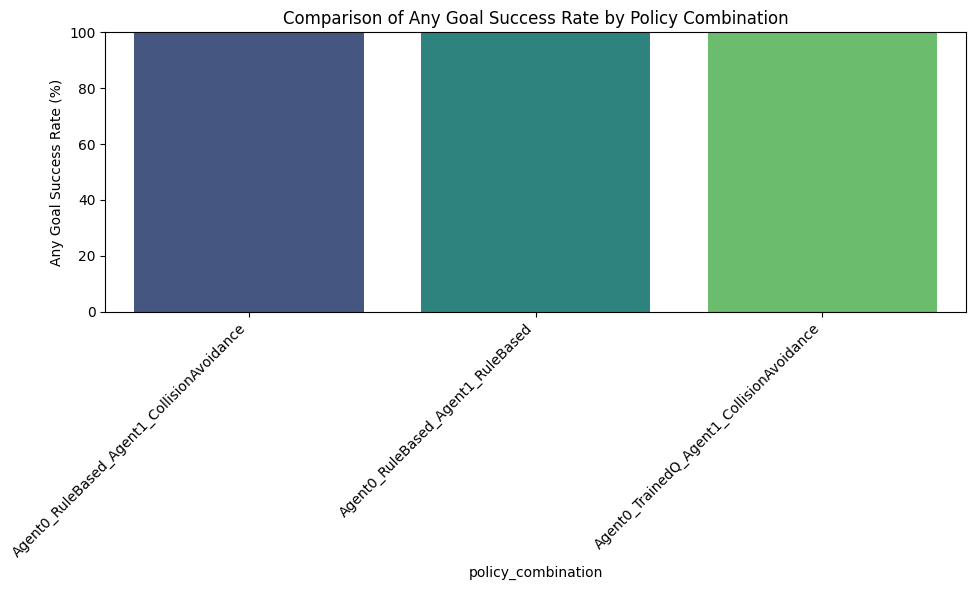

/tmp/ipython-input-1902645954.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)


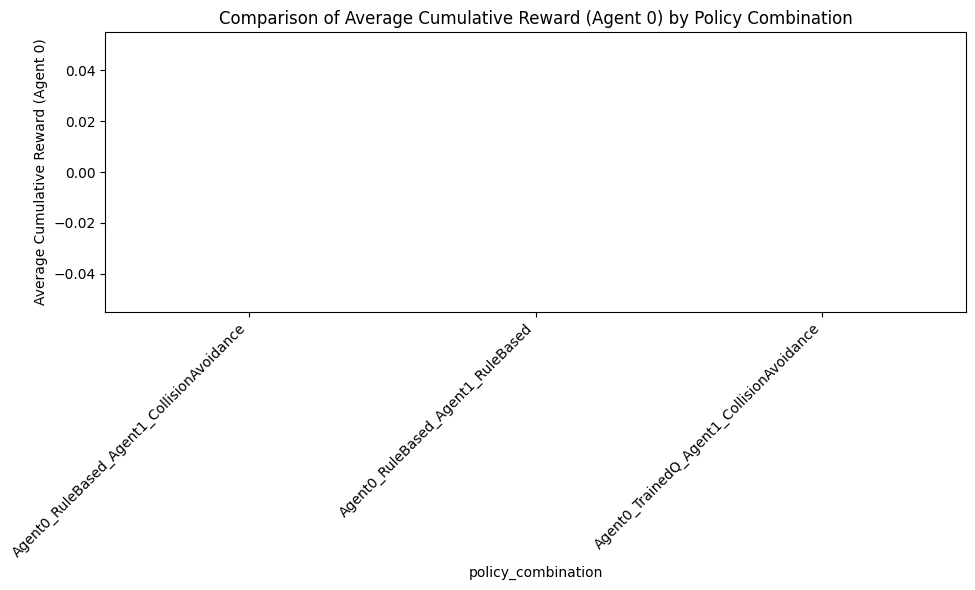

/tmp/ipython-input-1902645954.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)


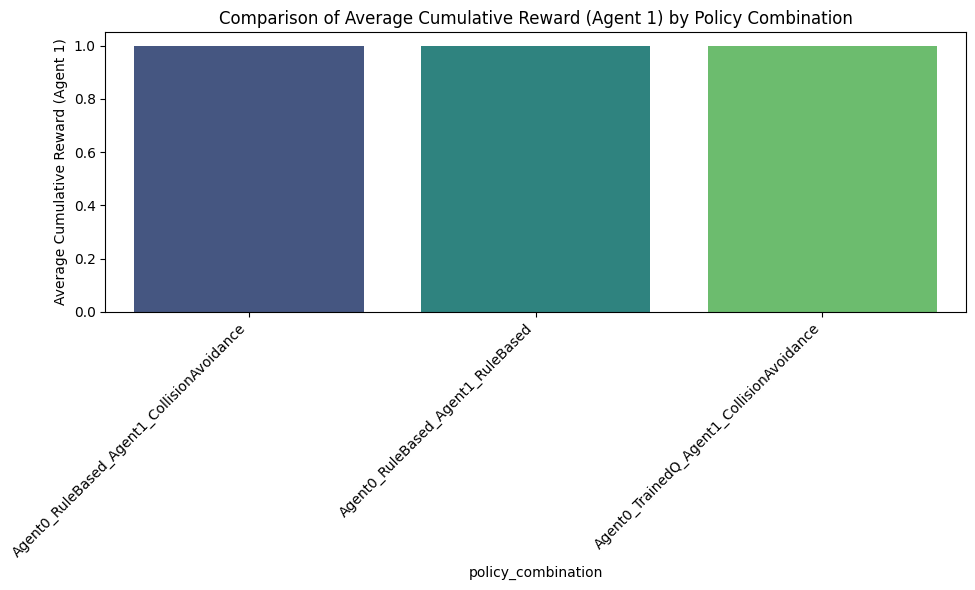

/tmp/ipython-input-1902645954.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)


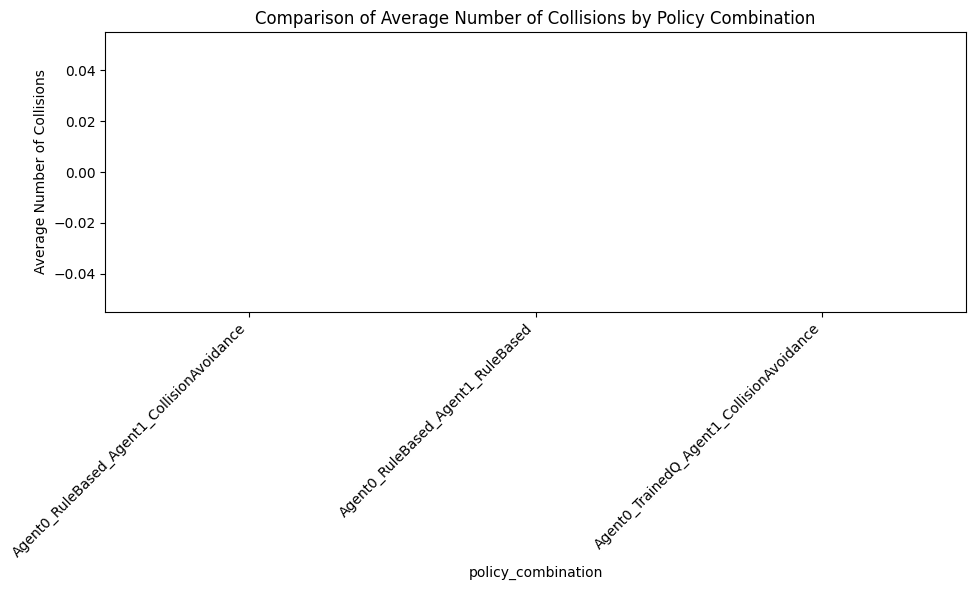

/tmp/ipython-input-1902645954.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)


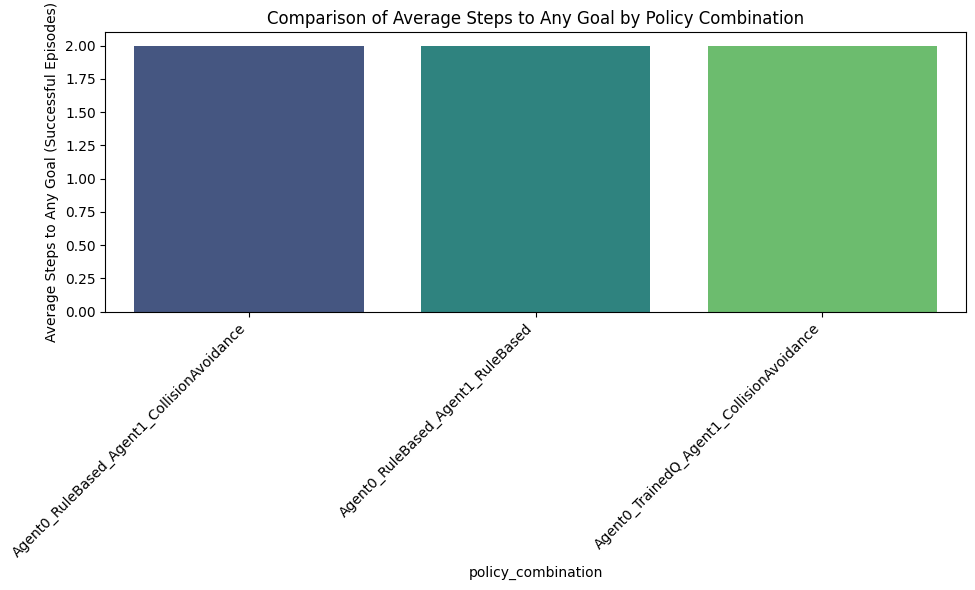

In [ ]:
# Group by policy combination and calculate average metrics
avg_metrics_combined = comparison_results_df.groupby('policy_combination').agg(
    Avg_Steps_to_Any_Goal=('steps_to_any_goal', lambda x: x[x != float('inf')].mean()),
    Avg_Cumulative_Reward_Agent0=('cumulative_reward_agent0', 'mean'),
    Avg_Cumulative_Reward_Agent1=('cumulative_reward_agent1', 'mean'),
    Avg_Num_Collisions=('num_collisions', 'mean'),
    Agent0_Goal_Success_Rate=('agent0_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Agent1_Goal_Success_Rate=('agent1_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Joint_Goal_Success_Rate=('joint_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Any_Goal_Success_Rate=('any_goal_achieved', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

print("--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---")
display(avg_metrics_combined)

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent color palette
palette = sns.color_palette("viridis", len(avg_metrics_combined['policy_combination']))

# Plot Any Goal Success Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)
plt.ylabel('Any Goal Success Rate (%)')
plt.title('Comparison of Any Goal Success Rate by Policy Combination')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 0
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 0)')
plt.title('Comparison of Average Cumulative Reward (Agent 0) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 1
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 1)')
plt.title('Comparison of Average Cumulative Reward (Agent 1) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plot Average Number of Collisions
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Number of Collisions')
plt.title('Comparison of Average Number of Collisions by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if not avg_metrics_combined['Avg_Steps_to_Any_Goal'].isnull().all():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)
    plt.ylabel('Average Steps to Any Goal (Successful Episodes)')
    plt.title('Comparison of Average Steps to Any Goal by Policy Combination')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot plotting Average Steps to Any Goal as no successful episodes were recorded.")

In [ ]:

print("\n--- Error Analysis ---")
if not error_analysis_df.empty:
    error_counts = error_analysis_df.groupby(['policy_combination', 'error_type']).size().unstack(fill_value=0)

    print("\n--- Error Frequency Analysis by Policy Combination and Error Type ---")
    display(error_counts)

    stalling_errors_rule_based = error_analysis_df[
        (error_analysis_df['policy_combination'] == 'Agent0_RuleBased_Agent1_RuleBased') &
        (error_analysis_df['error_type'] == 'Stalling')
    ]
    print("\nExample Stalling Errors for Agent0_RuleBased_Agent1_RuleBased:")
    display(stalling_errors_rule_based.head())


    collision_errors = error_analysis_df[error_analysis_df['error_type'].str.contains('Collision', na=False)]
    print("\nExample Collision Errors:")
    display(collision_errors.head())
else:
    print("No errors were logged during the simulation.")


--- Error Analysis ---
No errors were logged during the simulation.


In [ ]:

print("\n--- Error Analysis ---")
if not error_analysis_df.empty:
    error_counts = error_analysis_df.groupby(['policy_combination', 'error_type']).size().unstack(fill_value=0)

    print("\n--- Error Frequency Analysis by Policy Combination and Error Type ---")
    display(error_counts)

    stalling_errors_rule_based = error_analysis_df[
        (error_analysis_df['policy_combination'] == 'Agent0_RuleBased_Agent1_RuleBased') &
        (error_analysis_df['error_type'] == 'Stalling')
    ]
    print("\nExample Stalling Errors for Agent0_RuleBased_Agent1_RuleBased:")
    display(stalling_errors_rule_based.head())
    collision_errors = error_analysis_df[error_analysis_df['error_type'].str.contains('Collision', na=False)]
    print("\nExample Collision Errors:")
    display(collision_errors.head())
else:
    print("No errors were logged during the simulation.")


--- Error Analysis ---
No errors were logged during the simulation.


--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---


,policy_combination,Avg_Steps_to_Any_Goal,Avg_Cumulative_Reward_Agent0,Avg_Cumulative_Reward_Agent1,Avg_Num_Collisions,Agent0_Goal_Success_Rate,Agent1_Goal_Success_Rate,Joint_Goal_Success_Rate,Any_Goal_Success_Rate
0,Agent0_RuleBased_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
1,Agent0_RuleBased_Agent1_RuleBased,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0


/tmp/ipython-input-1902645954.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)


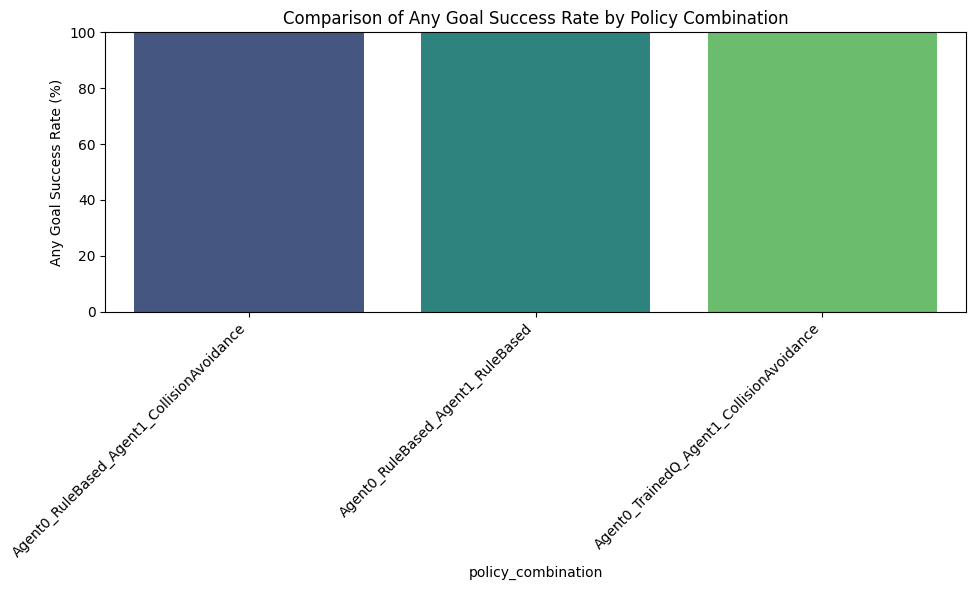

/tmp/ipython-input-1902645954.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)


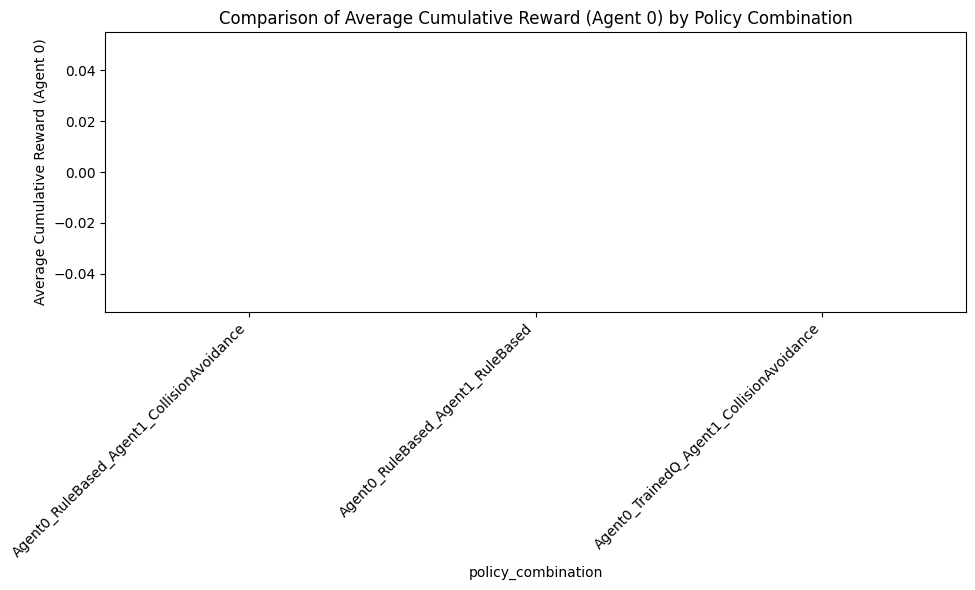

/tmp/ipython-input-1902645954.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)


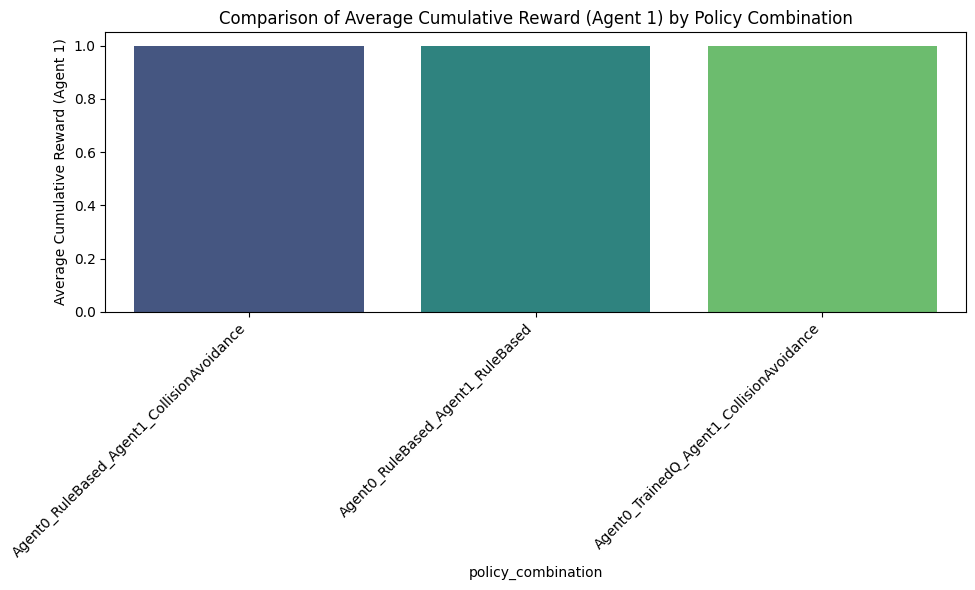

/tmp/ipython-input-1902645954.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)


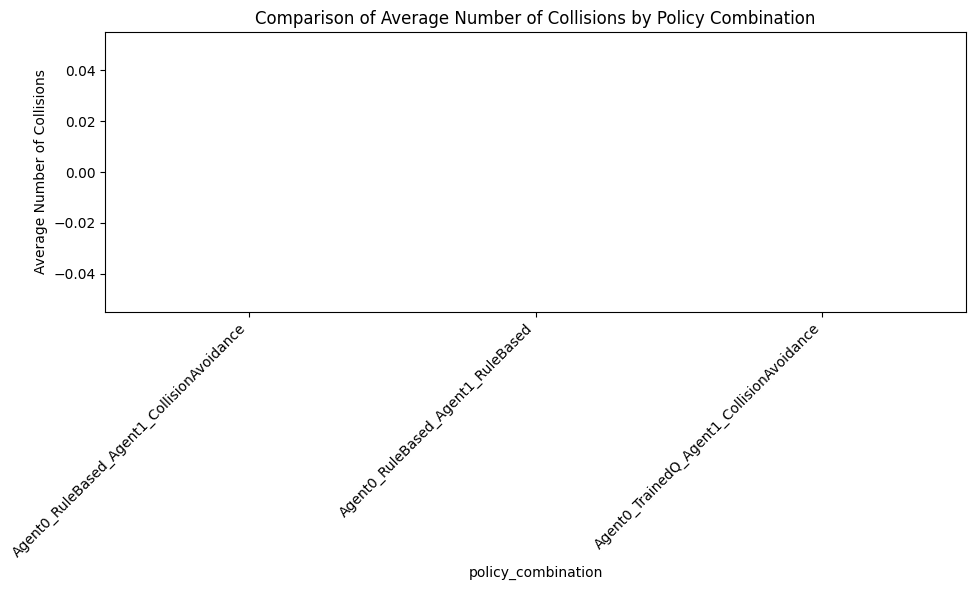

/tmp/ipython-input-1902645954.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)


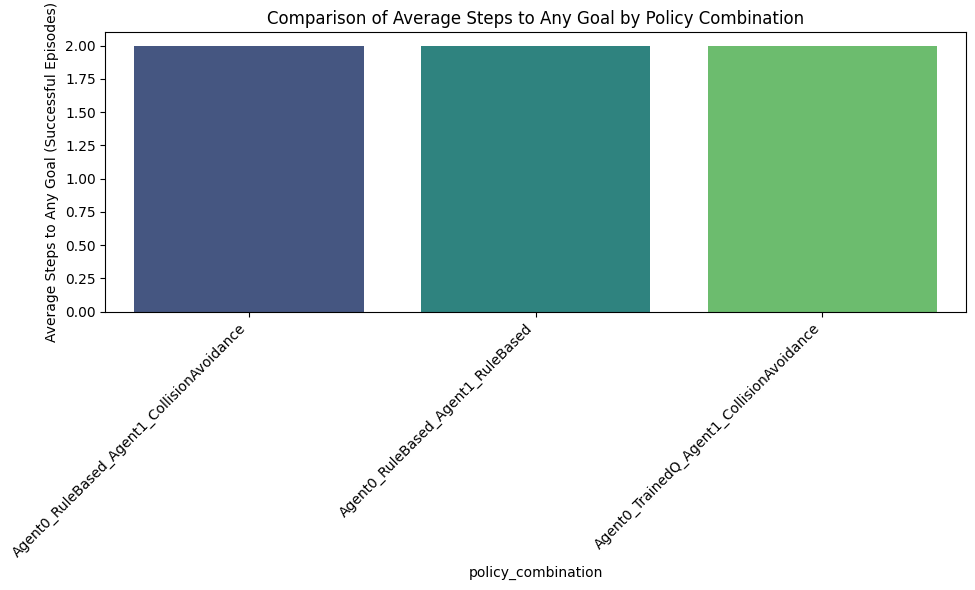

In [ ]:

# Group by policy combination and calculate average metrics
avg_metrics_combined = comparison_results_df.groupby('policy_combination').agg(
    Avg_Steps_to_Any_Goal=('steps_to_any_goal', lambda x: x[x != float('inf')].mean()),
    Avg_Cumulative_Reward_Agent0=('cumulative_reward_agent0', 'mean'),
    Avg_Cumulative_Reward_Agent1=('cumulative_reward_agent1', 'mean'),
    Avg_Num_Collisions=('num_collisions', 'mean'),
    Agent0_Goal_Success_Rate=('agent0_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Agent1_Goal_Success_Rate=('agent1_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Joint_Goal_Success_Rate=('joint_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Any_Goal_Success_Rate=('any_goal_achieved', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

print("--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---")
display(avg_metrics_combined)

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent color palette
palette = sns.color_palette("viridis", len(avg_metrics_combined['policy_combination']))

# Plot Any Goal Success Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)
plt.ylabel('Any Goal Success Rate (%)')
plt.title('Comparison of Any Goal Success Rate by Policy Combination')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 0
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 0)')
plt.title('Comparison of Average Cumulative Reward (Agent 0) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 1
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 1)')
plt.title('Comparison of Average Cumulative Reward (Agent 1) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plot Average Number of Collisions
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Number of Collisions')
plt.title('Comparison of Average Number of Collisions by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if not avg_metrics_combined['Avg_Steps_to_Any_Goal'].isnull().all():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)
    plt.ylabel('Average Steps to Any Goal (Successful Episodes)')
    plt.title('Comparison of Average Steps to Any Goal by Policy Combination')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot plotting Average Steps to Any Goal as no successful episodes were recorded.")

--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---


,policy_combination,Avg_Steps_to_Any_Goal,Avg_Cumulative_Reward_Agent0,Avg_Cumulative_Reward_Agent1,Avg_Num_Collisions,Agent0_Goal_Success_Rate,Agent1_Goal_Success_Rate,Joint_Goal_Success_Rate,Any_Goal_Success_Rate
0,Agent0_RuleBased_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
1,Agent0_RuleBased_Agent1_RuleBased,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0


/tmp/ipython-input-1902645954.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)


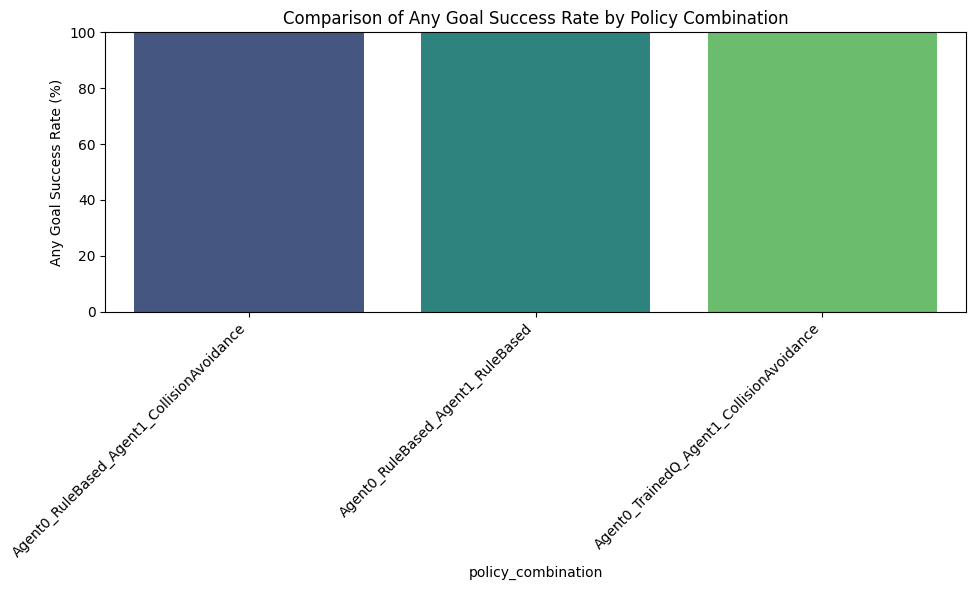

/tmp/ipython-input-1902645954.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)


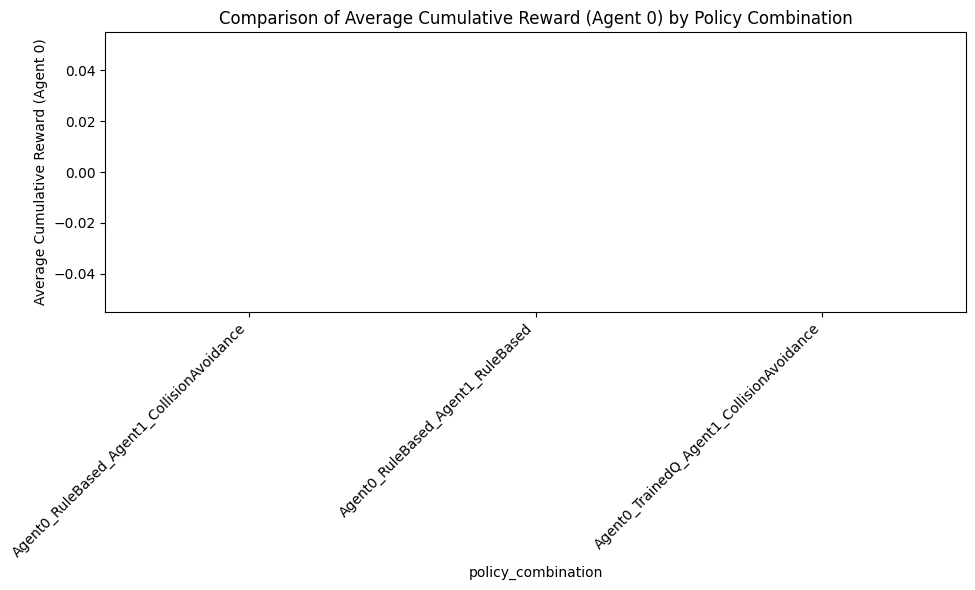

/tmp/ipython-input-1902645954.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)


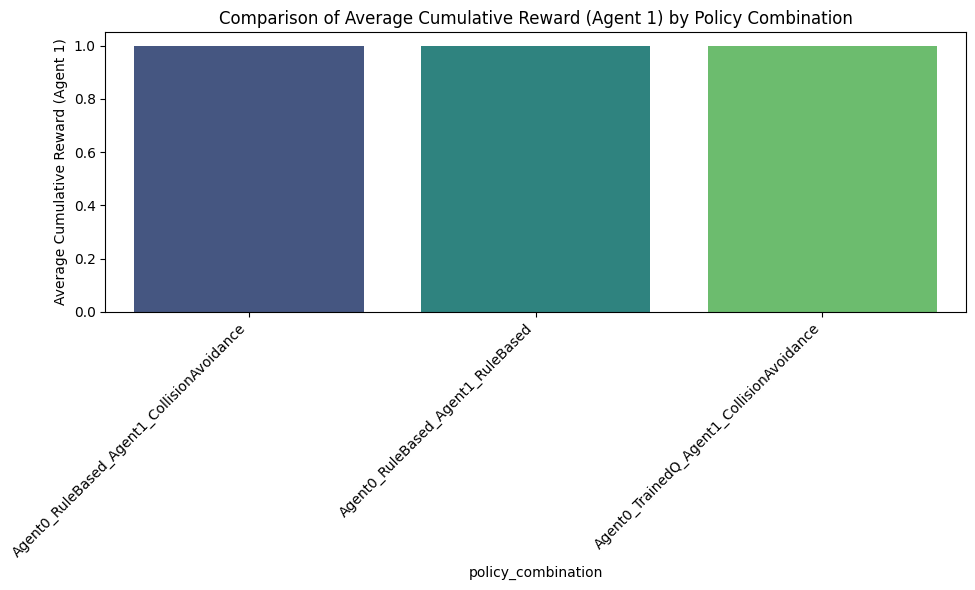

/tmp/ipython-input-1902645954.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)


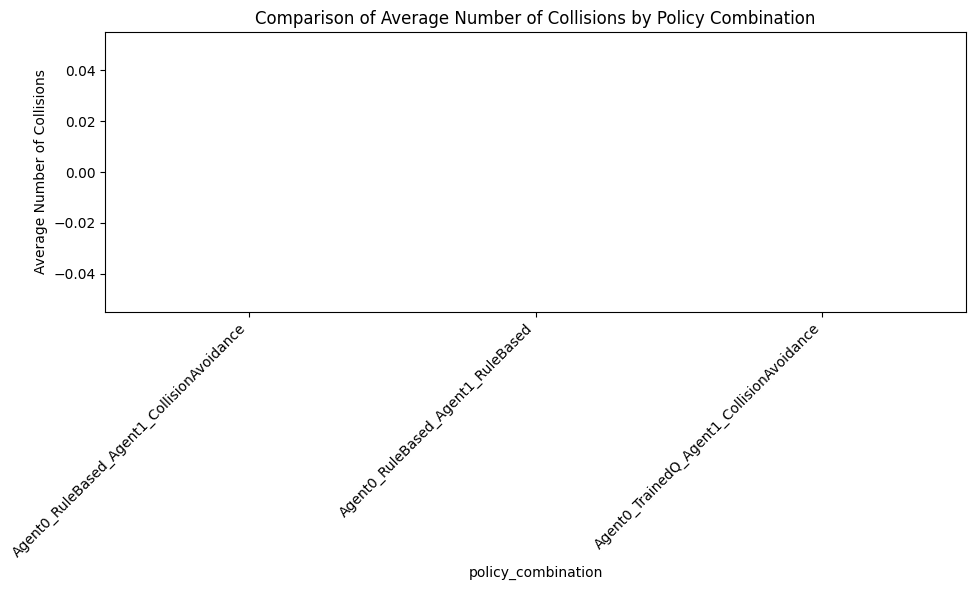

/tmp/ipython-input-1902645954.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)


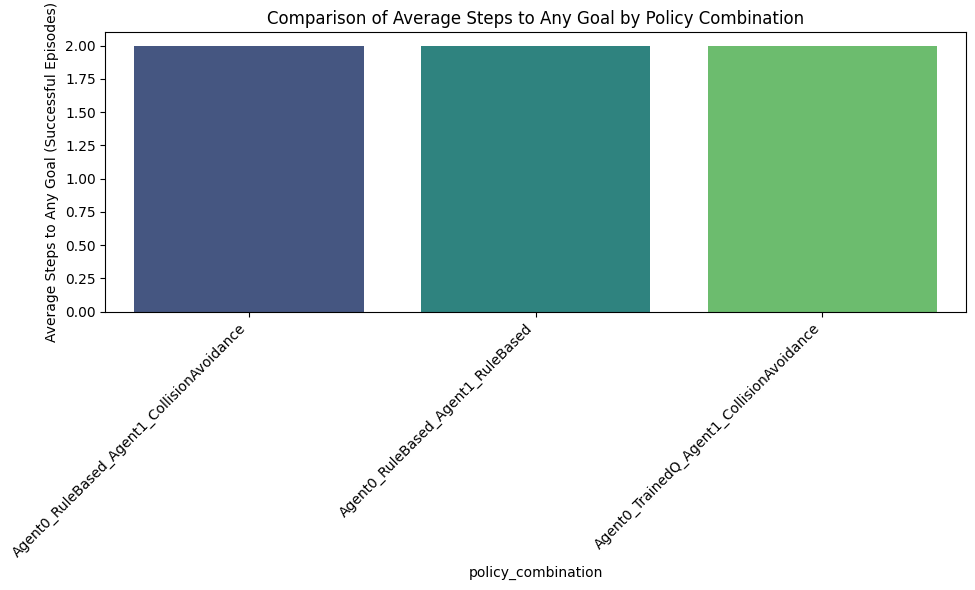

In [ ]:
# Group by policy combination and calculate average metrics
avg_metrics_combined = comparison_results_df.groupby('policy_combination').agg(
    Avg_Steps_to_Any_Goal=('steps_to_any_goal', lambda x: x[x != float('inf')].mean()),
    Avg_Cumulative_Reward_Agent0=('cumulative_reward_agent0', 'mean'),
    Avg_Cumulative_Reward_Agent1=('cumulative_reward_agent1', 'mean'),
    Avg_Num_Collisions=('num_collisions', 'mean'),
    Agent0_Goal_Success_Rate=('agent0_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Agent1_Goal_Success_Rate=('agent1_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Joint_Goal_Success_Rate=('joint_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Any_Goal_Success_Rate=('any_goal_achieved', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

print("--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---")
display(avg_metrics_combined)

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent color palette
palette = sns.color_palette("viridis", len(avg_metrics_combined['policy_combination']))

# Plot Any Goal Success Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)
plt.ylabel('Any Goal Success Rate (%)')
plt.title('Comparison of Any Goal Success Rate by Policy Combination')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 0
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 0)')
plt.title('Comparison of Average Cumulative Reward (Agent 0) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 1
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 1)')
plt.title('Comparison of Average Cumulative Reward (Agent 1) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plot Average Number of Collisions
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Number of Collisions')
plt.title('Comparison of Average Number of Collisions by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if not avg_metrics_combined['Avg_Steps_to_Any_Goal'].isnull().all():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)
    plt.ylabel('Average Steps to Any Goal (Successful Episodes)')
    plt.title('Comparison of Average Steps to Any Goal by Policy Combination')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot plotting Average Steps to Any Goal as no successful episodes were recorded.")

--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---


,policy_combination,Avg_Steps_to_Any_Goal,Avg_Cumulative_Reward_Agent0,Avg_Cumulative_Reward_Agent1,Avg_Num_Collisions,Agent0_Goal_Success_Rate,Agent1_Goal_Success_Rate,Joint_Goal_Success_Rate,Any_Goal_Success_Rate
0,Agent0_RuleBased_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
1,Agent0_RuleBased_Agent1_RuleBased,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0


/tmp/ipython-input-1902645954.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)


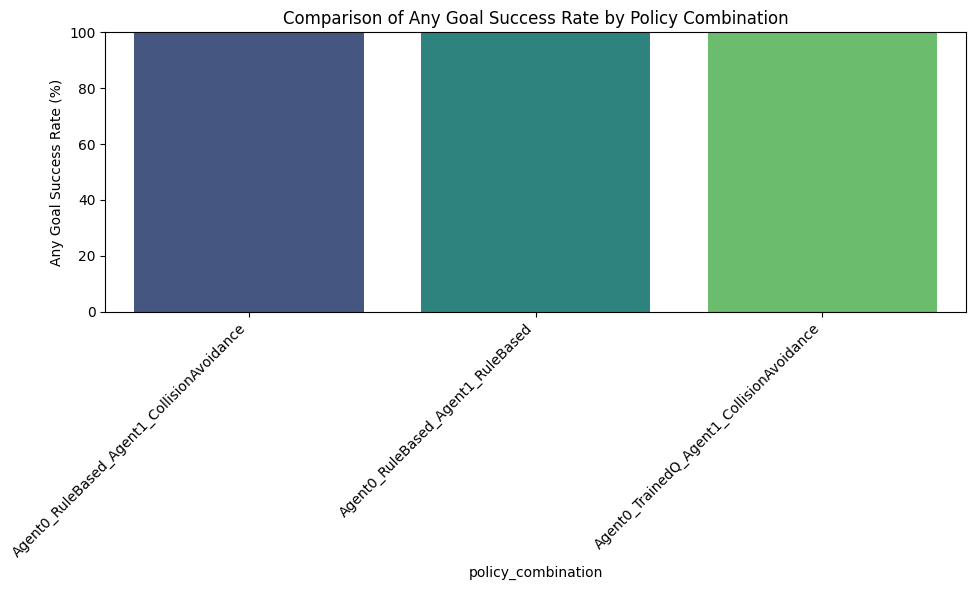

/tmp/ipython-input-1902645954.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)


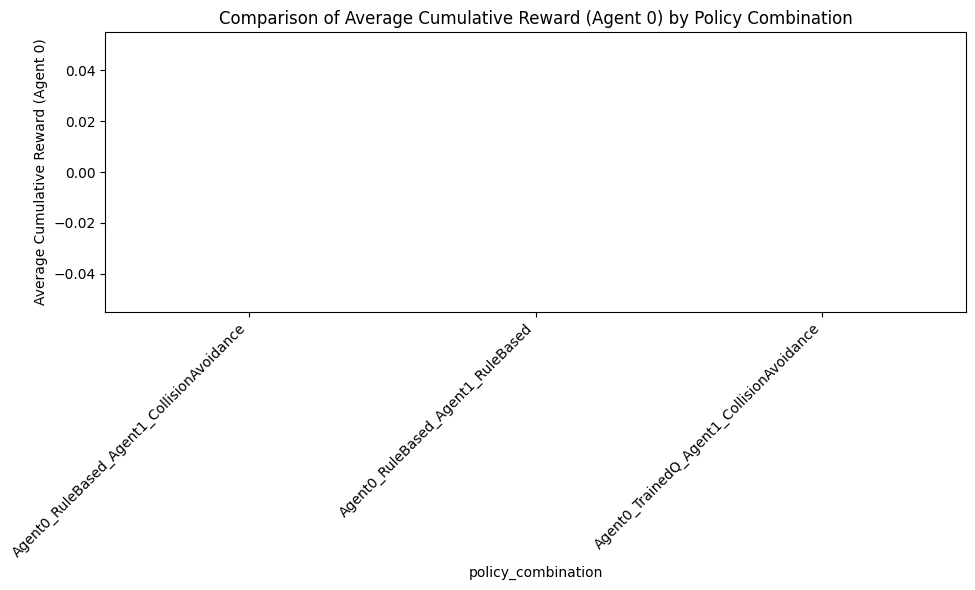

/tmp/ipython-input-1902645954.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)


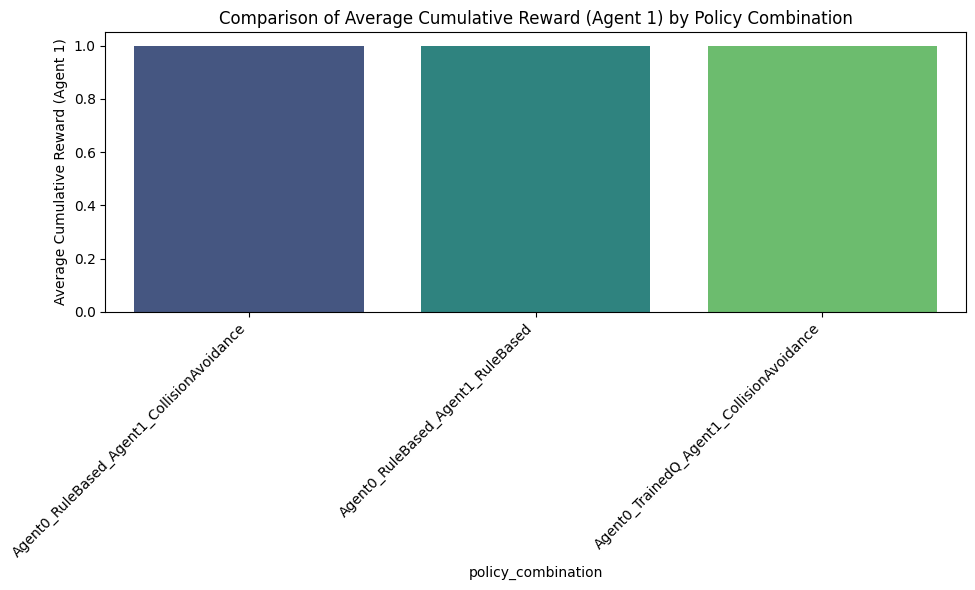

/tmp/ipython-input-1902645954.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)


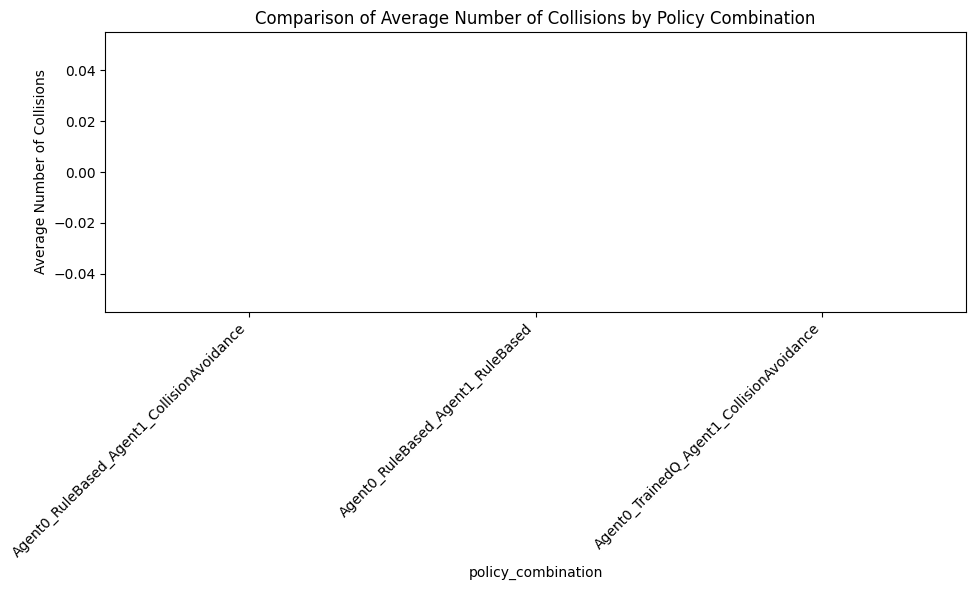

/tmp/ipython-input-1902645954.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)


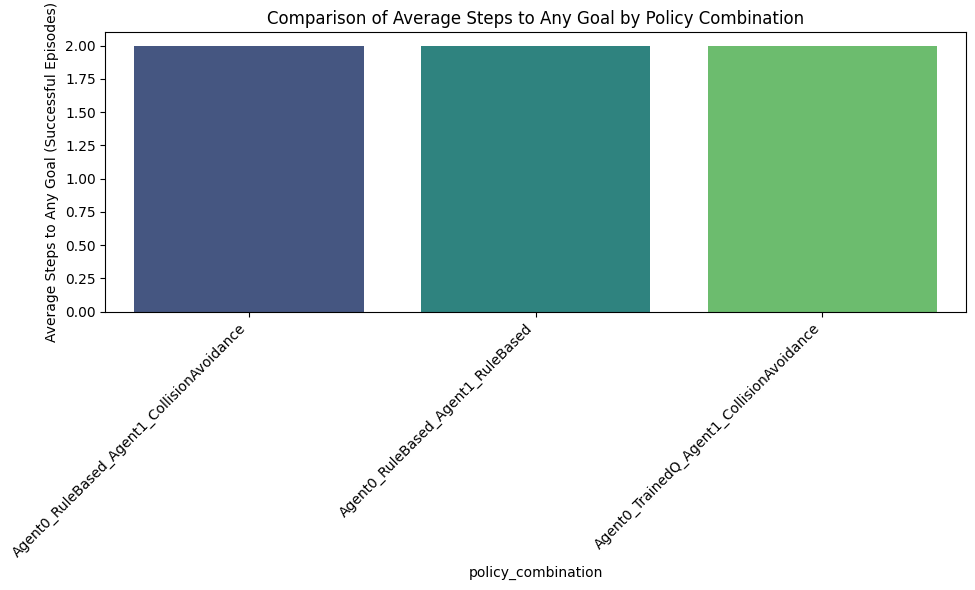

In [ ]:

# Group by policy combination and calculate average metrics
avg_metrics_combined = comparison_results_df.groupby('policy_combination').agg(
    Avg_Steps_to_Any_Goal=('steps_to_any_goal', lambda x: x[x != float('inf')].mean()),
    Avg_Cumulative_Reward_Agent0=('cumulative_reward_agent0', 'mean'),
    Avg_Cumulative_Reward_Agent1=('cumulative_reward_agent1', 'mean'),
    Avg_Num_Collisions=('num_collisions', 'mean'),
    Agent0_Goal_Success_Rate=('agent0_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Agent1_Goal_Success_Rate=('agent1_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Joint_Goal_Success_Rate=('joint_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Any_Goal_Success_Rate=('any_goal_achieved', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

print("--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---")
display(avg_metrics_combined)

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent color palette
palette = sns.color_palette("viridis", len(avg_metrics_combined['policy_combination']))

# Plot Any Goal Success Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)
plt.ylabel('Any Goal Success Rate (%)')
plt.title('Comparison of Any Goal Success Rate by Policy Combination')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 0
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 0)')
plt.title('Comparison of Average Cumulative Reward (Agent 0) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 1
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 1)')
plt.title('Comparison of Average Cumulative Reward (Agent 1) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plot Average Number of Collisions
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Number of Collisions')
plt.title('Comparison of Average Number of Collisions by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if not avg_metrics_combined['Avg_Steps_to_Any_Goal'].isnull().all():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)
    plt.ylabel('Average Steps to Any Goal (Successful Episodes)')
    plt.title('Comparison of Average Steps to Any Goal by Policy Combination')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot plotting Average Steps to Any Goal as no successful episodes were recorded.")

--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---


,policy_combination,Avg_Steps_to_Any_Goal,Avg_Cumulative_Reward_Agent0,Avg_Cumulative_Reward_Agent1,Avg_Num_Collisions,Agent0_Goal_Success_Rate,Agent1_Goal_Success_Rate,Joint_Goal_Success_Rate,Any_Goal_Success_Rate
0,Agent0_RuleBased_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
1,Agent0_RuleBased_Agent1_RuleBased,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2.0,0.0,1.0,0.0,0.0,100.0,0.0,100.0


/tmp/ipython-input-1902645954.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)


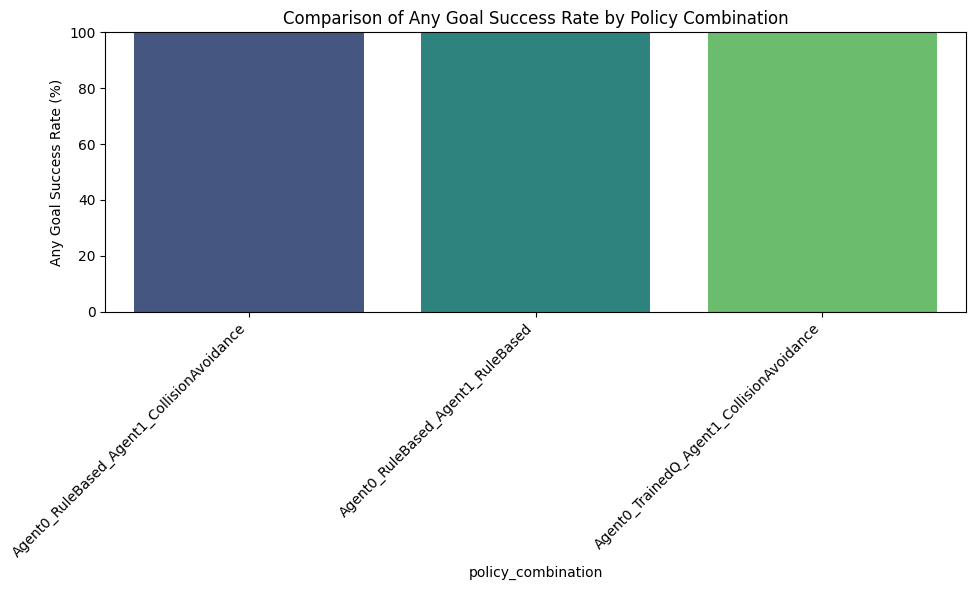

/tmp/ipython-input-1902645954.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)


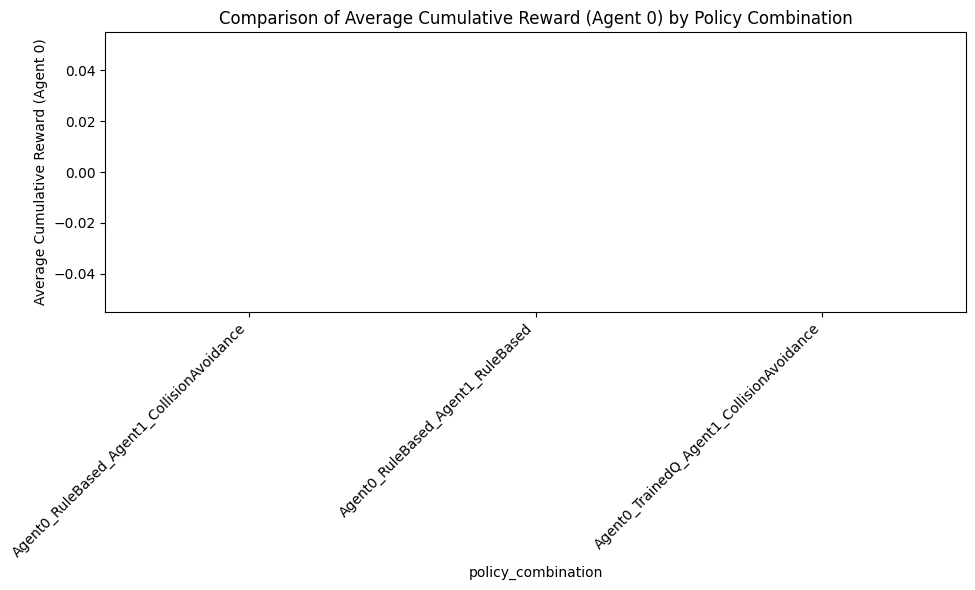

/tmp/ipython-input-1902645954.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)


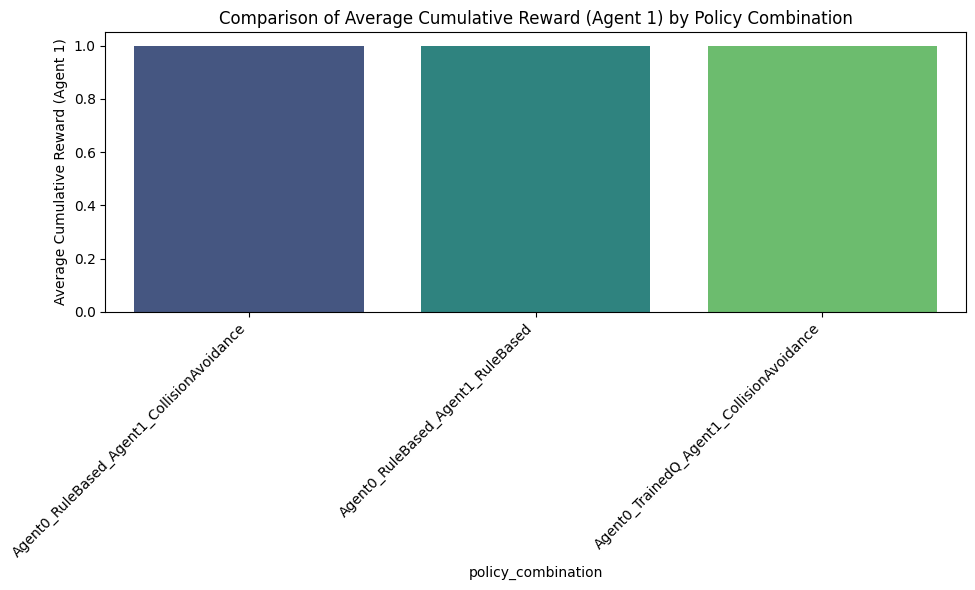

/tmp/ipython-input-1902645954.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)


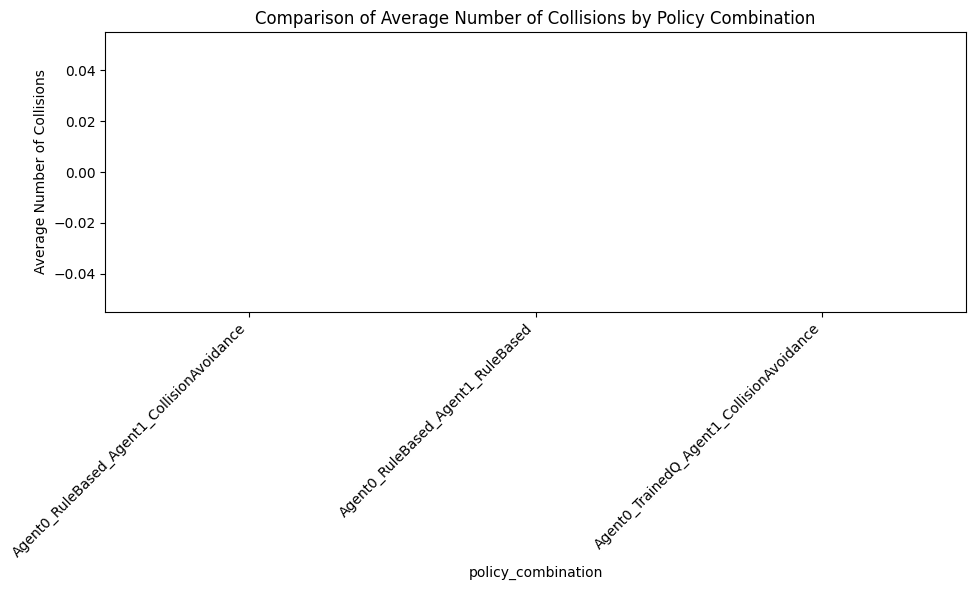

/tmp/ipython-input-1902645954.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)


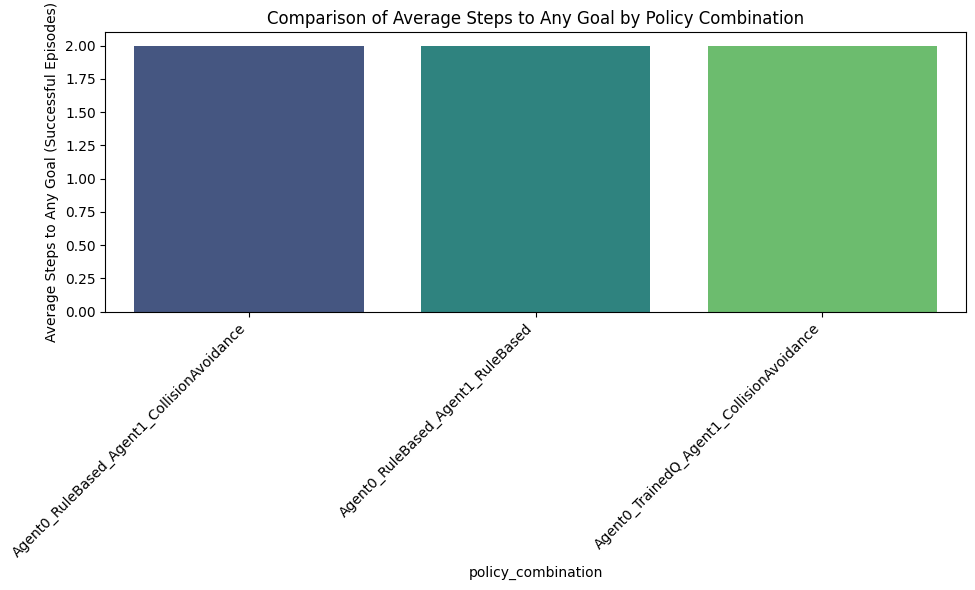

In [ ]:
# Buradi
# Group by policy combination and calculate average metrics
avg_metrics_combined = comparison_results_df.groupby('policy_combination').agg(
    Avg_Steps_to_Any_Goal=('steps_to_any_goal', lambda x: x[x != float('inf')].mean()),
    Avg_Cumulative_Reward_Agent0=('cumulative_reward_agent0', 'mean'),
    Avg_Cumulative_Reward_Agent1=('cumulative_reward_agent1', 'mean'),
    Avg_Num_Collisions=('num_collisions', 'mean'),
    Agent0_Goal_Success_Rate=('agent0_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Agent1_Goal_Success_Rate=('agent1_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Joint_Goal_Success_Rate=('joint_goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Any_Goal_Success_Rate=('any_goal_achieved', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

print("--- Comparative Performance Analysis of Multi-Agent Policy Combinations ---")
display(avg_metrics_combined)

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent color palette
palette = sns.color_palette("viridis", len(avg_metrics_combined['policy_combination']))

# Plot Any Goal Success Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Any_Goal_Success_Rate', data=avg_metrics_combined, palette=palette)
plt.ylabel('Any Goal Success Rate (%)')
plt.title('Comparison of Any Goal Success Rate by Policy Combination')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 0
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent0', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 0)')
plt.title('Comparison of Average Cumulative Reward (Agent 0) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average Cumulative Reward for Agent 1
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Cumulative_Reward_Agent1', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Cumulative Reward (Agent 1)')
plt.title('Comparison of Average Cumulative Reward (Agent 1) by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plot Average Number of Collisions
plt.figure(figsize=(10, 6))
sns.barplot(x='policy_combination', y='Avg_Num_Collisions', data=avg_metrics_combined, palette=palette)
plt.ylabel('Average Number of Collisions')
plt.title('Comparison of Average Number of Collisions by Policy Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if not avg_metrics_combined['Avg_Steps_to_Any_Goal'].isnull().all():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='policy_combination', y='Avg_Steps_to_Any_Goal', data=avg_metrics_combined.dropna(subset=['Avg_Steps_to_Any_Goal']), palette=palette)
    plt.ylabel('Average Steps to Any Goal (Successful Episodes)')
    plt.title('Comparison of Average Steps to Any Goal by Policy Combination')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot plotting Average Steps to Any Goal as no successful episodes were recorded.")

In [ ]:
# Inspect the columns of the error_analysis_df DataFrame
print("Columns in error_analysis_df:")
print(error_analysis_df.columns)

# Display the first few rows to see the data structure
print("\nHead of error_analysis_df:")
display(error_analysis_df.head())

Columns in error_analysis_df:
RangeIndex(start=0, stop=0, step=1)

Head of error_analysis_df:


""


### Evaluate Trained Agent 0 Q-Learning Policy vs Collision Avoidance Agent 1

This section evaluates the performance of Agent 0 using the trained Q-learning policy against Agent 1 using the `collision_avoidance_policy`.

In [ ]:
num_states_agent0 = env2.num_positions
num_actions_agent0 = env2.num_actions
Q_agent0 = np.zeros((num_states_agent0, num_actions_agent0))

alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epsilon = 0.5  # exploration rate (start higher for exploration)
epsilon_decay_rate = 0.99995 # Rate to decay epsilon each episode
min_epsilon = 0.01 # Minimum epsilon value

num_training_episodes_two_agent = 50000 # Sufficient number of episodes
max_steps_per_episode_two_agent = 200 # Limit steps per episode

print(f"Training Agent 0 Q-learning policy in TwoAgentEnv for {num_training_episodes_two_agent} episodes...")

for episode in range(num_training_episodes_two_agent):
    state_pair = env2.reset() # state_pair is [pos0, pos1]
    done = False
    episode_steps = 0

    while not done and episode_steps < max_steps_per_episode_two_agent:
        agent0_position = state_pair[0]
        if np.random.rand() < epsilon:
            action0 = np.random.randint(num_actions_agent0)
        else:
            if agent0_position < Q_agent0.shape[0]:
                 action0 = np.argmax(Q_agent0[agent0_position])
            else:
                 action0 = np.random.randint(num_actions_agent0) # Fallback

        agent1_position = state_pair[1]
        action1 = collision_avoidance_policy(env2, agent1_position, agent0_position)

        actions = [action0, action1]

        next_state_pair, base_rewards, done, flags = env2.step(actions)

        adjusted_rewards = env2.after_step(base_rewards, flags)

        next_agent0_position = next_state_pair[0]
        if next_agent0_position < Q_agent0.shape[0]:
             best_next_action_agent0 = np.argmax(Q_agent0[next_agent0_position])
             td_target_agent0 = adjusted_rewards[0] + gamma * Q_agent0[next_agent0_position, best_next_action_agent0]
             Q_agent0[agent0_position, action0] += alpha * (td_target_agent0 - Q_agent0[agent0_position, action0])


        state_pair = next_state_pair
        episode_steps += 1

    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)

print("\nTraining finished.")
print("Learned Q-table for Agent 0 in TwoAgentEnv (against collision avoidance Agent 1):")
print(Q_agent0)

Training Agent 0 Q-learning policy in TwoAgentEnv for 50000 episodes...

Training finished.
Learned Q-table for Agent 0 in TwoAgentEnv (against collision avoidance Agent 1):
[[-0.2  0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]


In [ ]:
try:
    env2
except NameError:
    env2 = TwoAgentEnv()

num_states_agent0 = env2.num_positions
num_actions_agent0 = env2.num_actions
Q_agent0 = np.zeros((num_states_agent0, num_actions_agent0))

alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epsilon = 0.5  # exploration rate (start higher for exploration)
epsilon_decay_rate = 0.99995 # Rate to decay epsilon each episode
min_epsilon = 0.01 # Minimum epsilon value

num_training_episodes_two_agent = 50000 # Sufficient number of episodes
max_steps_per_episode_two_agent = 200 # Limit steps per episode

print(f"Training Agent 0 Q-learning policy in TwoAgentEnv for {num_training_episodes_two_agent} episodes...")

for episode in range(num_training_episodes_two_agent):
    state_pair = env2.reset() # state_pair is [pos0, pos1]
    done = False
    episode_steps = 0

    while not done and episode_steps < max_steps_per_episode_two_agent:
        agent0_position = state_pair[0]
        if np.random.rand() < epsilon:
            action0 = np.random.randint(num_actions_agent0)
        else:
            if agent0_position < Q_agent0.shape[0]:
                 action0 = np.argmax(Q_agent0[agent0_position])
            else:
                 action0 = np.random.randint(num_actions_agent0) # Fallback


        agent1_position = state_pair[1]
        action1 = collision_avoidance_policy(env2, agent1_position, agent0_position)

        actions = [action0, action1]

        next_state_pair, base_rewards, done, flags = env2.step(actions)

        adjusted_rewards = env2.after_step(base_rewards, flags)

        next_agent0_position = next_state_pair[0]
        if next_agent0_position < Q_agent0.shape[0]:
             best_next_action_agent0 = np.argmax(Q_agent0[next_agent0_position])
             td_target_agent0 = adjusted_rewards[0] + gamma * Q_agent0[next_agent0_position, best_next_action_agent0]
             Q_agent0[agent0_position, action0] += alpha * (td_target_agent0 - Q_agent0[agent0_position, action0])


        state_pair = next_state_pair
        episode_steps += 1

    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)

print("\nTraining finished.")
print("Learned Q-table for Agent 0 in TwoAgentEnv (against collision avoidance Agent 1):")
print(Q_agent0)

Training Agent 0 Q-learning policy in TwoAgentEnv for 50000 episodes...

Training finished.
Learned Q-table for Agent 0 in TwoAgentEnv (against collision avoidance Agent 1):
[[-0.2  0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]


In [ ]:
# Evaluate the trained Q-learning policy for Agent 0

num_evaluation_episodes_two_agent = 1000 # Evaluate over a reasonable number of episodes
max_steps_per_episode_eval_two_agent = 200 # Use the same step limit as training

evaluation_results_two_agent = []

print(f"\nEvaluating trained Agent 0 policy for {num_evaluation_episodes_two_agent} episodes...")

for episode in range(num_evaluation_episodes_two_agent):
    state_pair = env2.reset() # Use the same environment
    done = False
    episode_steps = 0
    episode_cumulative_reward_agent0 = 0 # Track reward specifically for Agent 0

    while not done and episode_steps < max_steps_per_episode_eval_two_agent:
        # Agent 0 uses the trained Q-table (greedy)
        agent0_position = state_pair[0]
        # Ensure agent0_position is within Q_agent0 bounds
        if agent0_position < Q_agent0.shape[0]:
             action0 = np.argmax(Q_agent0[agent0_position])
        else:
             action0 = np.random.randint(env2.num_actions) # Fallback

        # Agent 1 still uses the collision_avoidance_policy
        agent1_position = state_pair[1]
        action1 = collision_avoidance_policy(env2, agent1_position, agent0_position)

        actions = [action0, action1]

        next_state_pair, base_rewards, done, flags = env2.step(actions)

        # Apply penalties using after_step
        adjusted_rewards = env2.after_step(base_rewards, flags)

        episode_cumulative_reward_agent0 += adjusted_rewards[0] # Add Agent 0's adjusted reward

        state_pair = next_state_pair
        episode_steps += 1

    # Store results for this episode
    evaluation_results_two_agent.append({
        'episode': episode,
        'steps_to_goal': episode_steps if done else float('inf'), # Steps until *any* agent reaches goal
        'agent0_goal_achieved': (state_pair[0] == env2.goal), # Did Agent 0 reach the goal?
        'agent1_goal_achieved': (state_pair[1] == env2.goal), # Did Agent 1 reach the goal?
        'any_goal_achieved': done, # Did *at least one* agent reach the goal?
        'cumulative_reward_agent0': episode_cumulative_reward_agent0,
        'total_steps_in_episode': episode_steps
    })

print("Evaluation finished.")

# Analyze evaluation results
evaluation_results_df_two_agent = pd.DataFrame(evaluation_results_two_agent)

# Calculate metrics
agent0_success_rate = evaluation_results_df_two_agent['agent0_goal_achieved'].mean() * 100
any_agent_success_rate = evaluation_results_df_two_agent['any_goal_achieved'].mean() * 100
avg_steps_to_any_goal = evaluation_results_df_two_agent[evaluation_results_df_two_agent['any_goal_achieved']]['steps_to_goal'].mean()
avg_cumulative_reward_agent0 = evaluation_results_df_two_agent['cumulative_reward_agent0'].mean()
avg_total_steps_eval = evaluation_results_df_two_agent['total_steps_in_episode'].mean()

print("\n--- Evaluation Performance Analysis (Trained Agent 0 vs. Collision Avoidance Agent 1) ---")
print(f"Agent 0 Goal Success Rate: {agent0_success_rate:.2f}%")
print(f"Any Agent Goal Success Rate: {any_agent_success_rate:.2f}%")
print(f"Average Steps to Any Goal (successful episodes only): {avg_steps_to_any_goal:.2f}" if not evaluation_results_df_two_agent[evaluation_results_df_two_agent['any_goal_achieved']].empty else "N/A (No successful episodes)")
print(f"Average Cumulative Reward for Agent 0: {avg_cumulative_reward_agent0:.2f}")
print(f"Average Total Steps per Episode: {avg_total_steps_eval:.2f}")




Evaluating trained Agent 0 policy for 1000 episodes...
Evaluation finished.

--- Evaluation Performance Analysis (Trained Agent 0 vs. Collision Avoidance Agent 1) ---
Agent 0 Goal Success Rate: 0.00%
Any Agent Goal Success Rate: 100.00%
Average Steps to Any Goal (successful episodes only): 2.00
Average Cumulative Reward for Agent 0: 0.00
Average Total Steps per Episode: 2.00


In [ ]:
try:
    env2
except NameError:
    env2 = TwoAgentEnv()
    print("Warning: env2 not found. Initializing TwoAgentEnv.")



def placeholder_policy_agent0(env, state_pair):
    """Placeholder policy for agent 0 - always moves right."""
    return 1

def placeholder_policy_agent1(env, state_pair):
    """Placeholder policy for agent 1 - always moves left."""
    return 0

policy_combinations = [
    {
        'name': 'Placeholder_Agent0_Right_Agent1_Left',
        'policy_agent0': placeholder_policy_agent0,
        'policy_agent1': placeholder_policy_agent1
    },

     {
         'name': 'Agent0_TrainedQ_Agent1_RuleBased', # Changed name to reflect the actual policy used
         'policy_agent0': q_policy_agent0_eval_wrapped, # Replaced placeholder with the wrapped trained Q policy
         'policy_agent1': rule_based_policy_two_agent # Assuming rule_based_policy_two_agent is defined
     },
]

# Initialize empty lists to store results and error data.
comparison_results = []
error_analysis_data = [] # To collect data for error analysis (e.g., collisions, stalling)

# Set simulation parameters
num_episodes_comp = 100 # Number of episodes per policy combination
max_steps_per_episode_comp = 100 # Maximum steps per episode to prevent infinite loops

print(f"Starting simulation for comparative analysis over {num_episodes_comp} episodes per combination...")

# Loop through each defined policy combination.
for policy_comb in policy_combinations:
    policy_comb_name = policy_comb['name']
    policy_agent0 = policy_comb['policy_agent0']
    policy_agent1 = policy_comb['policy_agent1']

    print(f"\nRunning episodes for combination: {policy_comb_name}")

    # Inside the policy combination loop, loop through episodes.
    for episode in range(num_episodes_comp):
        # Reset the TwoAgentEnv and initialize episode-specific variables.
        state_pair = env2.reset() # state_pair is [pos0, pos1]
        done = False
        episode_steps = 0
        episode_cumulative_reward_agent0 = 0.0
        episode_cumulative_reward_agent1 = 0.0
        episode_state_history = [state_pair] # Store state pair history
        num_collisions = 0 # Metric for error analysis

        # Within the episode loop, while the episode is not done and within a maximum step limit:
        while not done and episode_steps < max_steps_per_episode_comp:
            # Get current state pair before determining actions
            current_state_pair = state_pair

            # Determine actions for Agent 0 and Agent 1 by calling their respective policy functions.
            # Policies should be designed to accept (env, state_pair) and return action (int).
            # If policies require more arguments (like a Q_table), they should be wrapped or curried.
            action0 = policy_agent0(env2, current_state_pair)
            action1 = policy_agent1(env2, current_state_pair)
            actions = [action0, action1]

            # Call the env2.step() method.
            # Assuming env2.step returns next_state_pair, rewards (list), done, flags (dict)
            next_state_pair, base_rewards, done, flags = env2.step(actions)

            # Call the env2.after_step() method to get adjusted rewards.
            # env2.after_step expects rewards as a list and flags as a dict
            adjusted_rewards = env2.after_step(base_rewards, flags)

            # Update the episode's cumulative reward for each agent.
            episode_cumulative_reward_agent0 += adjusted_rewards[0]
            episode_cumulative_reward_agent1 += adjusted_rewards[1]

            # Update the current state pair to the next state pair.
            state_pair = next_state_pair

            # Increment the episode step counter.
            episode_steps += 1

            # Append the current state to the episode's state history.
            episode_state_history.append(state_pair)

            # Implement basic error detection (e.g., stalling, collision).
            # Check for stalling (both agents in the same position as the previous step)
            if next_state_pair == current_state_pair and episode_steps > 1:
                 error_analysis_data.append({
                     'policy_combination': policy_comb_name,
                     'episode': episode,
                     'step': episode_steps,
                     'state_pair': current_state_pair,
                     'actions': actions,
                     'next_state_pair': next_state_pair,
                     'error_type': 'Stalling'
                 })

            # Check for collisions (if flags indicate collision)
            if flags.get('collision', False):
                 num_collisions += 1
                 # Optionally log collision errors as well
                 error_analysis_data.append({
                     'policy_combination': policy_comb_name,
                     'episode': episode,
                     'step': episode_steps,
                     'state_pair': current_state_pair,
                     'actions': actions,
                     'next_state_pair': next_state_pair,
                     'error_type': 'Collision'
                 })


        # After the episode loop finishes, store the episode's results.
        # Determine goal achievement status
        agent0_goal_achieved = (state_pair[0] == env2.goal)
        agent1_goal_achieved = (state_pair[1] == env2.goal)
        # Joint goal achievement: both reached the goal simultaneously in the final state
        joint_goal_achieved = agent0_goal_achieved and agent1_goal_achieved


        comparison_results.append({
            'policy_combination': policy_comb_name,
            'episode': episode,
            'steps_to_any_goal': episode_steps if done else float('inf'), # Steps to reach *any* goal
            'agent0_goal_achieved': agent0_goal_achieved,
            'agent1_goal_achieved': agent1_goal_achieved,
            'joint_goal_achieved': joint_goal_achieved,
            'any_goal_achieved': done, # True if at least one agent reached goal
            'cumulative_reward_agent0': episode_cumulative_reward_agent0,
            'cumulative_reward_agent1': episode_cumulative_reward_agent1,
            'total_steps_in_episode': episode_steps,
            'num_collisions': num_collisions # Store collision count per episode
        })

print("\nSimulation finished for all combinations.")

# Convert the collected results and error analysis data into pandas DataFrames.
comparison_results_df = pd.DataFrame(comparison_results)
error_analysis_df = pd.DataFrame(error_analysis_data)

print("\nComparison Results DataFrame Head:")
display(comparison_results_df.head())

print("\nError Analysis DataFrame Head:")
display(error_analysis_df.head())

Starting simulation for comparative analysis over 100 episodes per combination...

Running episodes for combination: Placeholder_Agent0_Right_Agent1_Left

Running episodes for combination: Agent0_TrainedQ_Agent1_RuleBased

Simulation finished for all combinations.

Comparison Results DataFrame Head:


,policy_combination,episode,steps_to_any_goal,agent0_goal_achieved,agent1_goal_achieved,joint_goal_achieved,any_goal_achieved,cumulative_reward_agent0,cumulative_reward_agent1,total_steps_in_episode,num_collisions
0,Placeholder_Agent0_Right_Agent1_Left,0,4,True,False,False,True,0.0,-1.4,4,1
1,Placeholder_Agent0_Right_Agent1_Left,1,4,True,False,False,True,0.0,-1.4,4,1
2,Placeholder_Agent0_Right_Agent1_Left,2,4,True,False,False,True,0.0,-1.4,4,1
3,Placeholder_Agent0_Right_Agent1_Left,3,4,True,False,False,True,0.0,-1.4,4,1
4,Placeholder_Agent0_Right_Agent1_Left,4,4,True,False,False,True,0.0,-1.4,4,1



Error Analysis DataFrame Head:


,policy_combination,episode,step,state_pair,actions,next_state_pair,error_type
0,Placeholder_Agent0_Right_Agent1_Left,0,1,"[0, 2]","[1, 0]","[1, 1]",Collision
1,Placeholder_Agent0_Right_Agent1_Left,1,1,"[0, 2]","[1, 0]","[1, 1]",Collision
2,Placeholder_Agent0_Right_Agent1_Left,2,1,"[0, 2]","[1, 0]","[1, 1]",Collision
3,Placeholder_Agent0_Right_Agent1_Left,3,1,"[0, 2]","[1, 0]","[1, 1]",Collision
4,Placeholder_Agent0_Right_Agent1_Left,4,1,"[0, 2]","[1, 0]","[1, 1]",Collision


### Conduct Comparative Analysis and Error Analysis

This section conducts a comparative analysis of the rule-based policy and the Q-learning policy trained in the obstacle environment, including performance metrics and visualization.

Running 1000 episodes for each policy for comparative and error analysis...

Running episodes for: RuleBasedPolicy

Running episodes for: TrainedQPolicy

Simulation finished.

--- Comparative Performance Analysis ---
            policy  Average_Steps_to_Goal  Average_Cumulative_Reward  \
0  RuleBasedPolicy                    NaN                 -4995.1000   
1   TrainedQPolicy                    NaN                  -102.7489   

   Goal_Success_Rate  Average_Total_Steps  
0                0.0               1000.0  
1                0.0               1000.0  

--- Error Analysis ---

Error Frequency by Policy and Type:
error_type       Stalling
policy                   
RuleBasedPolicy    999000
TrainedQPolicy     950461

Example Error Instances:


,policy,episode,step,state,action,next_state,error_type
0,RuleBasedPolicy,0,2,1,1,1,Stalling
1,RuleBasedPolicy,0,3,1,1,1,Stalling
2,RuleBasedPolicy,0,4,1,1,1,Stalling
3,RuleBasedPolicy,0,5,1,1,1,Stalling
4,RuleBasedPolicy,0,6,1,1,1,Stalling


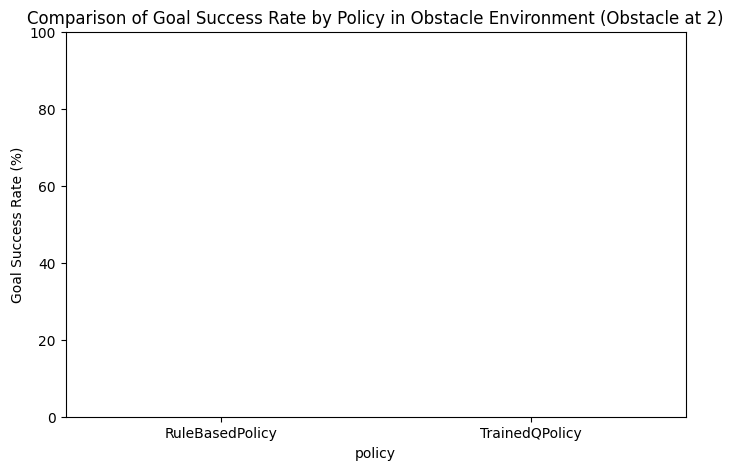

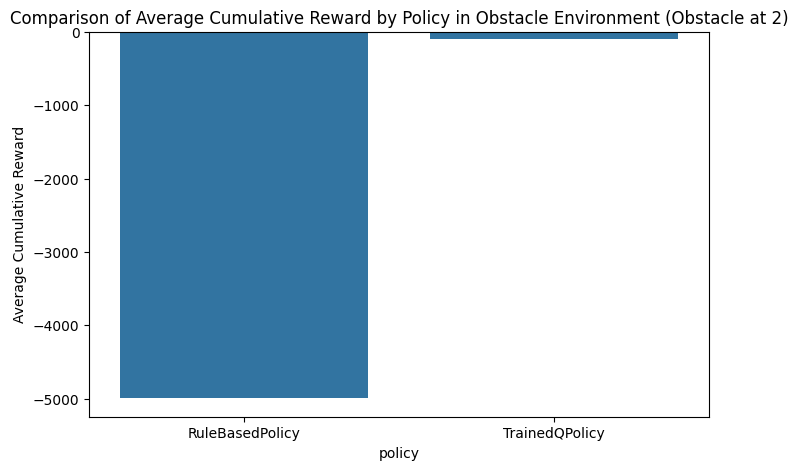

In [ ]:
# Conduct Comparative Analysis and Error Analysis

env_obstacle_comp = SimpleEnv(n_positions=5, obstacles=[2], obstacle_penalty=-5.0)


def rule_based_policy_comp(state):
    return 1

def q_policy_trained_obstacle_comp(env, state, Q_table):
    # Use argmax for greedy evaluation with the trained Q-table
    if state < Q_table.shape[0]:
         # Add a small epsilon for exploration during evaluation in the modified env
         epsilon_eval = 0.05
         if np.random.rand() < epsilon_eval:
             return np.random.randint(env.num_actions)
         else:
             return int(np.argmax(Q_table[state]))
    else:
         # Fallback for unseen states (should not happen in this 1D env)
         return np.random.randint(env.num_actions)

# --- Simulation and Data Collection ---

num_comparison_episodes = 1000 # Use a sufficient number of episodes for comparison
max_steps_per_episode_comp = 1000 # Increased step limit for comparative analysis

comparison_results = []
error_analysis_data = []

policies_to_compare = {
    'RuleBasedPolicy': rule_based_policy_comp,
    'TrainedQPolicy': lambda env, state: q_policy_trained_obstacle_comp(env, state, Q_obstacle) # Wrap Q policy to match expected signature
}

print(f"Running {num_comparison_episodes} episodes for each policy for comparative and error analysis...")

for policy_name, policy_func in policies_to_compare.items():
    print(f"\nRunning episodes for: {policy_name}")
    for episode in range(num_comparison_episodes):
        state = env_obstacle_comp.reset()
        done = False
        episode_steps = 0
        episode_cumulative_reward = 0
        episode_state_history = [state]

        while not done and episode_steps < max_steps_per_episode_comp:
            # Determine action based on policy. Need to handle policy signature differences.
            if policy_name == 'RuleBasedPolicy':
                action = policy_func(state)
            else: # TrainedQPolicy needs env and state
                 action = policy_func(env_obstacle_comp, state)


            next_state, reward, done, info = env_obstacle_comp.step(action)

            episode_steps += 1
            episode_cumulative_reward += reward
            episode_state_history.append(next_state)

            # --- Basic Error Detection ---
            error_type = None
            if next_state == state and episode_steps > 1: # Check for stalling after the first step
                 error_type = 'Stalling'

            if error_type:
                 error_analysis_data.append({
                     'policy': policy_name,
                     'episode': episode,
                     'step': episode_steps,
                     'state': state,
                     'action': action,
                     'next_state': next_state,
                     'error_type': error_type
                 })
            # --- End Error Detection ---

            state = next_state

            if done:
                break

        # Store results for this episode
        comparison_results.append({
            'policy': policy_name,
            'episode': episode,
            'steps_to_goal': episode_steps if done else float('inf'),
            'cumulative_reward': episode_cumulative_reward,
            'goal_achieved': done,
            'total_steps_in_episode': episode_steps
        })

print("\nSimulation finished.")

# --- Comparative Analysis ---

comparison_results_df = pd.DataFrame(comparison_results)

print("\n--- Comparative Performance Analysis ---")
print(comparison_results_df.groupby('policy').agg(
    Average_Steps_to_Goal=('steps_to_goal', lambda x: x[x != float('inf')].mean()),
    Average_Cumulative_Reward=('cumulative_reward', 'mean'),
    Goal_Success_Rate=('goal_achieved', lambda x: (x.sum() / len(x)) * 100),
    Average_Total_Steps=('total_steps_in_episode', 'mean')
).reset_index())

# --- Error Analysis ---

error_analysis_df = pd.DataFrame(error_analysis_data)

print("\n--- Error Analysis ---")
if not error_analysis_df.empty:
    print("\nError Frequency by Policy and Type:")
    print(error_analysis_df.groupby(['policy', 'error_type']).size().unstack(fill_value=0))

    print("\nExample Error Instances:")
    display(error_analysis_df.head())

else:
    print("No errors detected based on the defined error types.")

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Bar chart for Success Rate
avg_metrics_comp = comparison_results_df.groupby('policy').agg(
    success_rate=('goal_achieved', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='policy', y='success_rate', data=avg_metrics_comp)
plt.ylabel('Goal Success Rate (%)')
plt.title('Comparison of Goal Success Rate by Policy in Obstacle Environment (Obstacle at 2)')
plt.ylim(0, 100)
plt.show()

# Example: Bar chart for Average Cumulative Reward
avg_metrics_comp = comparison_results_df.groupby('policy').agg(
    avg_reward=('cumulative_reward', 'mean')
).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='policy', y='avg_reward', data=avg_metrics_comp)
plt.ylabel('Average Cumulative Reward')
plt.title('Comparison of Average Cumulative Reward by Policy in Obstacle Environment (Obstacle at 2)')
plt.show()

In [ ]:
def rule_based_policy_two_agent(env, agent_position):
    return 1

def q_policy_two_agent(env, state_pair, Q_table, agent_index, epsilon=0.0):

    agent_position = state_pair[agent_index]
    # Ensure the agent's position is within the bounds of the Q-table
    if agent_position < Q_table.shape[0]:
        if np.random.rand() < epsilon:
            return np.random.randint(env.num_actions)
        else:
            return int(np.argmax(Q_table[agent_position]))
    else:
        # Fallback for unexpected states (should not happen in this env)
        return np.random.randint(env.num_actions)

def collision_avoidance_policy(env, agent_position, other_agent_position):

    # Default action is to move right towards the goal
    preferred_action = 1

    # Predict the next position if both agents move right
    predicted_next_agent_pos = min(env.num_positions - 1, agent_position + 1)
    predicted_next_other_agent_pos = min(env.num_positions - 1, other_agent_position + 1)

    # If moving right would result in a collision (and not at the goal), consider moving left
    if predicted_next_agent_pos == predicted_next_other_agent_pos and predicted_next_agent_pos != env.goal:
        # Check if moving left avoids the collision and doesn't move away from the goal unnecessarily
        next_pos_if_left = max(0, agent_position - 1)
        # Simple check: if moving left doesn't take us further from the goal than staying put
        if abs(env.goal - next_pos_if_left) <= abs(env.goal - agent_position):
             preferred_action = 0 # Choose left to avoid collision

    return preferred_action

def combined_policy_two_agent(env, state_pair, policy_agent0, policy_agent1):

    try:
        # Attempt to call with common args first
        action0 = policy_agent0(env, state_pair)
    except TypeError:

        if policy_agent0.__name__ == 'q_policy_two_agent':
                       # Let's assume the policies passed here conform to the (env, state_pair) -> action signature.
             action0 = policy_agent0(env, state_pair) # This assumes policies handle their own args internally
        elif policy_agent0.__name__ == 'rule_based_policy_two_agent':
             action0 = policy_agent0(env, state_pair[0]) # Rule based only needs its position
        else:
             # Fallback or raise error if policy signature is unknown
             print(f"Warning: Unknown policy signature for agent 0: {policy_agent0.__name__}. Attempting call with (env, state_pair).")
             action0 = policy_agent0(env, state_pair) # Attempt generic call

    # Call agent 1's policy - need to handle different policy signatures
    try:
        # Attempt to call with common args first
        action1 = policy_agent1(env, state_pair)
    except TypeError:
        # Try calling with args specific to known policies
        if policy_agent1.__name__ == 'q_policy_two_agent':
             # Similar issue as agent 0's Q policy - needs Q_table and agent_index
             # This function definition needs refinement. See note above.
             # Assuming wrapped/curried policy:
             action1 = policy_agent1(env, state_pair) # Assuming policies handle their own args internally
        elif policy_agent1.__name__ == 'collision_avoidance_policy':
             action1 = policy_agent1(env, state_pair[1], state_pair[0]) # Collision avoidance needs both positions
        elif policy_agent1.__name__ == 'rule_based_policy_two_agent':
             action1 = policy_agent1(env, state_pair[1]) # Rule based only needs its position
        else:
             # Fallback or raise error
             print(f"Warning: Unknown policy signature for agent 1: {policy_agent1.__name__}. Attempting call with (env, state_pair).")
             action1 = policy_agent1(env, state_pair) # Attempt generic call


    return [action0, action1]

# Example Usage (Conceptual - requires defined Q_table if using q_policy_two_agent)
env2 = TwoAgentEnv()
# Assuming Q_agent0 is defined elsewhere, e.g., from training
# If not, you might need to initialize it or train first
try:
    Q_agent0
except NameError:
    # Initialize with zeros if not trained yet
    print("Warning: Q_agent0 not found. Initializing with zeros for example usage.")
    Q_agent0 = np.zeros((env2.num_positions, env2.num_actions))


q_policy_agent0_wrapped = lambda e, s: q_policy_two_agent(e, s, Q_agent0, agent_index=0, epsilon=0.1)

collision_policy_agent1_wrapped = lambda e, s_pair: collision_avoidance_policy(e, s_pair[1], s_pair[0])

# Combine the wrapped policies
combined_policy_example = lambda e, s: combined_policy_two_agent(e, s, q_policy_agent0_wrapped, collision_policy_agent1_wrapped)

state = env2.reset()
actions = combined_policy_example(env2, state)
print(f"Initial State: {state}, Chosen Actions: {actions}")
next_state, rewards, done, flags = env2.step(actions)
adjusted_rewards = env2.after_step(rewards, flags)
print(f"Next State: {next_state}, Rewards: {rewards}, Adjusted Rewards: {adjusted_rewards}")

Initial State: [0, 2], Chosen Actions: [1, 1]
Next State: [1, 3], Rewards: [0.0, 0.0], Adjusted Rewards: [0.0, 0.0]


In [ ]:
try:
    env2
except NameError:
    env2 = TwoAgentEnv()

num_states_agent0 = env2.num_positions
num_actions_agent0 = env2.num_actions
Q_agent0 = np.zeros((num_states_agent0, num_actions_agent0))


alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epsilon = 0.5  # exploration rate (start higher for exploration)
epsilon_decay_rate = 0.99995 # Rate to decay epsilon each episode
min_epsilon = 0.01 # Minimum epsilon value


num_training_episodes_two_agent = 50000 # Sufficient number of episodes
max_steps_per_episode_two_agent = 200 # Limit steps per episode

print(f"Training Agent 0 Q-learning policy in TwoAgentEnv for {num_training_episodes_two_agent} episodes...")

for episode in range(num_training_episodes_two_agent):

    state_pair = env2.reset() # state_pair is [pos0, pos1]
    done = False
    episode_steps = 0


    while not done and episode_steps < max_steps_per_episode_two_agent:
        # a. Agent 0 selects an action using an epsilon-greedy approach
        agent0_position = state_pair[0]
        if np.random.rand() < epsilon:
            action0 = np.random.randint(num_actions_agent0)
        else:
            # Ensure agent0_position is within Q_agent0 bounds
            if agent0_position < Q_agent0.shape[0]:
                 action0 = np.argmax(Q_agent0[agent0_position])
            else:
                 action0 = np.random.randint(num_actions_agent0) # Fallback

        agent1_position = state_pair[1]
        action1 = collision_avoidance_policy(env2, agent1_position, agent0_position)

        actions = [action0, action1]

        next_state_pair, base_rewards, done, flags = env2.step(actions)


        adjusted_rewards = env2.after_step(base_rewards, flags)


        next_agent0_position = next_state_pair[0]
        if next_agent0_position < Q_agent0.shape[0]:
             best_next_action_agent0 = np.argmax(Q_agent0[next_agent0_position])
             td_target_agent0 = adjusted_rewards[0] + gamma * Q_agent0[next_agent0_position, best_next_action_agent0]
             Q_agent0[agent0_position, action0] += alpha * (td_target_agent0 - Q_agent0[agent0_position, action0])
        # else: no Q update if next state is out of bounds (shouldn't happen in this env)


        state_pair = next_state_pair
        episode_steps += 1


    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)

print("\nTraining finished.")
print("Learned Q-table for Agent 0 in TwoAgentEnv (against collision avoidance Agent 1):")
print(Q_agent0)

Training Agent 0 Q-learning policy in TwoAgentEnv for 50000 episodes...

Training finished.
Learned Q-table for Agent 0 in TwoAgentEnv (against collision avoidance Agent 1):
[[-0.2  0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]


In [ ]:
# Evaluate the trained Q-learning policy for Agent 0

num_evaluation_episodes_two_agent = 1000 # Evaluate over a reasonable number of episodes
max_steps_per_episode_eval_two_agent = 200 # Use the same step limit as training

evaluation_results_two_agent = []

print(f"\nEvaluating trained Agent 0 policy for {num_evaluation_episodes_two_agent} episodes...")

for episode in range(num_evaluation_episodes_two_agent):
    state_pair = env2.reset() # Use the same environment
    done = False
    episode_steps = 0
    episode_cumulative_reward_agent0 = 0 # Track reward specifically for Agent 0

    while not done and episode_steps < max_steps_per_episode_eval_two_agent:
        # Agent 0 uses the trained Q-table (greedy)
        agent0_position = state_pair[0]
        # Ensure agent0_position is within Q_agent0 bounds
        if agent0_position < Q_agent0.shape[0]:
             action0 = np.argmax(Q_agent0[agent0_position])
        else:
             action0 = np.random.randint(env2.num_actions) # Fallback

        # Agent 1 still uses the collision_avoidance_policy
        agent1_position = state_pair[1]
        action1 = collision_avoidance_policy(env2, agent1_position, agent0_position)

        actions = [action0, action1]

        next_state_pair, base_rewards, done, flags = env2.step(actions)

        # Apply penalties using after_step
        adjusted_rewards = env2.after_step(base_rewards, flags)

        episode_cumulative_reward_agent0 += adjusted_rewards[0] # Add Agent 0's adjusted reward

        state_pair = next_state_pair
        episode_steps += 1

    # Store results for this episode
    evaluation_results_two_agent.append({
        'episode': episode,
        'steps_to_goal': episode_steps if done else float('inf'), # Steps until *any* agent reaches goal
        'agent0_goal_achieved': (state_pair[0] == env2.goal), # Did Agent 0 reach the goal?
        'agent1_goal_achieved': (state_pair[1] == env2.goal), # Did Agent 1 reach the goal?
        'any_goal_achieved': done, # Did *at least one* agent reach the goal?
        'cumulative_reward_agent0': episode_cumulative_reward_agent0,
        'total_steps_in_episode': episode_steps
    })

print("Evaluation finished.")

# Analyze evaluation results
evaluation_results_df_two_agent = pd.DataFrame(evaluation_results_two_agent)

# Calculate metrics
agent0_success_rate = evaluation_results_df_two_agent['agent0_goal_achieved'].mean() * 100
any_agent_success_rate = evaluation_results_df_two_agent['any_goal_achieved'].mean() * 100
avg_steps_to_any_goal = evaluation_results_df_two_agent[evaluation_results_df_two_agent['any_goal_achieved']]['steps_to_goal'].mean()
avg_cumulative_reward_agent0 = evaluation_results_df_two_agent['cumulative_reward_agent0'].mean()
avg_total_steps_eval = evaluation_results_df_two_agent['total_steps_in_episode'].mean()

print("\n--- Evaluation Performance Analysis (Trained Agent 0 vs. Collision Avoidance Agent 1) ---")
print(f"Agent 0 Goal Success Rate: {agent0_success_rate:.2f}%")
print(f"Any Agent Goal Success Rate: {any_agent_success_rate:.2f}%")
print(f"Average Steps to Any Goal (successful episodes only): {avg_steps_to_any_goal:.2f}" if not evaluation_results_df_two_agent[evaluation_results_df_two_agent['any_goal_achieved']].empty else "N/A (No successful episodes)")
print(f"Average Cumulative Reward for Agent 0: {avg_cumulative_reward_agent0:.2f}")
print(f"Average Total Steps per Episode: {avg_total_steps_eval:.2f}")


Evaluating trained Agent 0 policy for 1000 episodes...
Evaluation finished.

--- Evaluation Performance Analysis (Trained Agent 0 vs. Collision Avoidance Agent 1) ---
Agent 0 Goal Success Rate: 0.00%
Any Agent Goal Success Rate: 100.00%
Average Steps to Any Goal (successful episodes only): 2.00
Average Cumulative Reward for Agent 0: 0.00
Average Total Steps per Episode: 2.00


In [ ]:
try:
    Q_agent0
except NameError:
    print("Warning: Q_agent0 not found. Initializing a zero Q-table for Agent 0.")
    env2 = TwoAgentEnv() # Ensure env2 is available
    Q_agent0 = np.zeros((env2.num_positions, env2.num_actions))

try:
    env2
except NameError:
    env2 = TwoAgentEnv()
    print("Warning: env2 not found. Initializing TwoAgentEnv.")

q_policy_agent0_eval_wrapped = lambda env, state_pair: q_policy_two_agent(env, state_pair, Q_agent0, agent_index=0, epsilon=0.0)

# Collision avoidance policy for Agent 1
collision_policy_agent1_wrapped = lambda env, state_pair: collision_avoidance_policy(env, state_pair[1], state_pair[0])

# Rule-based policy for Agent 0 (always right)
rule_policy_agent0_wrapped = lambda env, state_pair: rule_based_policy_two_agent(env, state_pair[0])

# Rule-based policy for Agent 1 (always right)
rule_policy_agent1_wrapped = lambda env, state_pair: rule_based_policy_two_agent(env, state_pair[1])


policy_combinations = [
    {
        'name': 'Agent0_TrainedQ_Agent1_CollisionAvoidance',
        'policy_agent0': q_policy_agent0_eval_wrapped,
        'policy_agent1': collision_policy_agent1_wrapped
    },
    {
        'name': 'Agent0_RuleBased_Agent1_RuleBased',
        'policy_agent0': rule_policy_agent0_wrapped,
        'policy_agent1': rule_policy_agent1_wrapped
    },
    {
        'name': 'Agent0_RuleBased_Agent1_CollisionAvoidance',
        'policy_agent0': rule_policy_agent0_wrapped,
        'policy_agent1': collision_policy_agent1_wrapped
    },
    # Add other combinations as needed for comparison
]

comparison_results = []
error_analysis_data = []

num_episodes_comp = 1000 # Number of episodes per policy combination
max_steps_per_episode_comp = 200 # Maximum steps per episode

print(f"Starting simulation for comparative analysis over {num_episodes_comp} episodes per combination...")

for policy_comb in policy_combinations:
    policy_comb_name = policy_comb['name']
    policy_agent0 = policy_comb['policy_agent0']
    policy_agent1 = policy_comb['policy_agent1']

    print(f"\nRunning episodes for combination: {policy_comb_name}")

    for episode in range(num_episodes_comp):
        state_pair = env2.reset() # state_pair is [pos0, pos1]
        done = False
        episode_steps = 0
        episode_cumulative_reward_agent0 = 0.0
        episode_cumulative_reward_agent1 = 0.0
        episode_state_history = [state_pair] # Store state pair history
        num_collisions = 0

        while not done and episode_steps < max_steps_per_episode_comp:
            current_state_pair = state_pair

            actions = combined_policy_two_agent(env2, current_state_pair, policy_agent0, policy_agent1)

            next_state_pair, base_rewards, done, flags = env2.step(actions)

            adjusted_rewards = env2.after_step(base_rewards, flags)

            episode_cumulative_reward_agent0 += adjusted_rewards[0]
            episode_cumulative_reward_agent1 += adjusted_rewards[1]

            state_pair = next_state_pair

            episode_steps += 1

            episode_state_history.append(state_pair)

            error_type = None
            if next_state_pair == current_state_pair and episode_steps > 1:
                 error_type = 'Stalling'

            if flags.get('collision', False):
                 num_collisions += 1
                 if error_type is None:
                     error_type = 'Collision'
                 else:
                     error_type += '_Collision'


            if error_type:
                 error_analysis_data.append({
                     'policy_combination': policy_comb_name,
                     'episode': episode,
                     'step': episode_steps,
                     'state_pair': current_state_pair,
                     'actions': actions,
                     'next_state_pair': next_state_pair,
                     'error_type': error_type
                 })

        agent0_goal_achieved = (state_pair[0] == env2.goal)
        agent1_goal_achieved = (state_pair[1] == env2.goal)
        joint_goal_achieved = agent0_goal_achieved and agent1_goal_achieved

        comparison_results.append({
            'policy_combination': policy_comb_name,
            'episode': episode,
            'steps_to_any_goal': episode_steps if done else float('inf'),
            'agent0_goal_achieved': agent0_goal_achieved,
            'agent1_goal_achieved': agent1_goal_achieved,
            'joint_goal_achieved': joint_goal_achieved,
            'any_goal_achieved': done,
            'cumulative_reward_agent0': episode_cumulative_reward_agent0,
            'cumulative_reward_agent1': episode_cumulative_reward_agent1,
            'total_steps_in_episode': episode_steps,
            'num_collisions': num_collisions
        })

print("\nSimulation finished for all combinations.")

comparison_results_df = pd.DataFrame(comparison_results)
error_analysis_df = pd.DataFrame(error_analysis_data)

print("\nComparison Results DataFrame Head:")
display(comparison_results_df.head())

print("\nError Analysis DataFrame Head:")
display(error_analysis_df.head())

Starting simulation for comparative analysis over 1000 episodes per combination...

Running episodes for combination: Agent0_TrainedQ_Agent1_CollisionAvoidance

Running episodes for combination: Agent0_RuleBased_Agent1_RuleBased

Running episodes for combination: Agent0_RuleBased_Agent1_CollisionAvoidance

Simulation finished for all combinations.

Comparison Results DataFrame Head:


,policy_combination,episode,steps_to_any_goal,agent0_goal_achieved,agent1_goal_achieved,joint_goal_achieved,any_goal_achieved,cumulative_reward_agent0,cumulative_reward_agent1,total_steps_in_episode,num_collisions
0,Agent0_TrainedQ_Agent1_CollisionAvoidance,0,2,False,True,False,True,0.0,1.0,2,0
1,Agent0_TrainedQ_Agent1_CollisionAvoidance,1,2,False,True,False,True,0.0,1.0,2,0
2,Agent0_TrainedQ_Agent1_CollisionAvoidance,2,2,False,True,False,True,0.0,1.0,2,0
3,Agent0_TrainedQ_Agent1_CollisionAvoidance,3,2,False,True,False,True,0.0,1.0,2,0
4,Agent0_TrainedQ_Agent1_CollisionAvoidance,4,2,False,True,False,True,0.0,1.0,2,0



Error Analysis DataFrame Head:


""
